# Finetune PaliGemma

> *These models and code are not official Google products and were trained and released for research purposes.*


**This notebook shows how to finetune PaliGemma on a vision-language task.**
The training data consists of 90 pairs of images and long captions describing them.
To make it runnable on a T4 colab runtime with 16GB HBM and 12GB RAM, we opt to only finetune the attention layers of the language model and freeze the other parameters.

 **This setup is illustrative**. In a real usecase, the amount of data, trainable parameters, training steps and hyper-parameters and obtained results could be significantly different.

This notebook uses the model reference implementation from [big_vision](https://github.com/google-research/big_vision).
and shows how to:

 * Install deps, download model checkpoint and training data.
 * Load the model onto GPU devices.
 * Prepare the input to the model for training and inference.
 * Finetune the model and inspect output in validation split.

## Setup

In [1]:
# @title Fetch big_vision code and install dependencies.
import os
import sys

# Fetch big_vision repository if python doesn't know about it and install
# dependencies needed for this notebook.
if not os.path.exists("big_vision_repo"):
  !git clone --quiet --branch=main --depth=1 \
     https://github.com/google-research/big_vision big_vision_repo

# Append big_vision code to python import path
if "big_vision_repo" not in sys.path:
  sys.path.append("big_vision_repo")

# Install missing dependencies. Assume jax~=0.4.25 with GPU available.
!pip install -q "overrides" "ml_collections" "einops~=0.7" "sentencepiece"

### Configure your API key to access Kaggle

To use PaliGemma, you must provide your Kaggle username and a Kaggle API key.

1. To generate a Kaggle API key, go to the **Account** tab of your Kaggle user profile and select **Create New Token**. This will trigger the download of a `kaggle.json` file containing your API credentials.
1. In Colab, select **Secrets** (🔑) in the left pane and add your Kaggle username and Kaggle API key. Store your username under the name `KAGGLE_USERNAME` and your API key under the name `KAGGLE_KEY`.

To be able to download, you will also need to acknowledge the Terms and Conditions of the PaliGemma on:

* https://www.kaggle.com/models/google/paligemma/



In [2]:
import os
#from google.colab import userdata

# Note: `userdata.get` is a Colab API. If you're not using Colab, set the env
# vars as appropriate or make your credentials available in ~/.kaggle/kaggle.json
#userdata.get('KAGGLE_USERNAME')
#userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = "mahirafser"
os.environ["KAGGLE_KEY"] = "68535df65e8a9e27270203c2cad6b043"

In [3]:
# @title Download checkpoint, tokenizer and dataset to local filesystem.
#
import os
import kagglehub

#MODEL_PATH = "./paligemma-3b-mix-448.f16.npz"
MODEL_PATH = "./paligemma-3b-mix-224.f16.npz"
if not os.path.exists(MODEL_PATH):
  print("Downloading the checkpoint from Kaggle, this could take a few minutes....")
  # Note: kaggle archive contains the same checkpoint in multiple formats.
  # Download only the float16 model.
  MODEL_PATH = kagglehub.model_download('google/paligemma/jax/paligemma-3b-mix-224', MODEL_PATH)
  #MODEL_PATH = kagglehub.model_download('google/paligemma/jax/paligemma-3b-mix-448', MODEL_PATH)
print(f"Model path: {MODEL_PATH}")
######Change model path google/paligemma/jax/paligemma-3b-mix-224 , google/paligemma/jax/paligemma-3b-mix-448
TOKENIZER_PATH = "./paligemma_tokenizer.model"
if not os.path.exists(TOKENIZER_PATH):
  print("Downloading the model tokenizer...")
  !gsutil cp gs://big_vision/paligemma_tokenizer.model {TOKENIZER_PATH}
  print(f"Tokenizer path: {TOKENIZER_PATH}")


Model path: /kaggle/input/paligemma/jax/paligemma-3b-mix-224/1/./paligemma-3b-mix-224.f16.npz
Copying gs://big_vision/paligemma_tokenizer.model...

Operation completed over 1 objects/4.1 MiB.                                      
Tokenizer path: ./paligemma_tokenizer.model


## Notebook

In [4]:
import base64
import functools
import html
import io
import os
import warnings

import jax
import jax.numpy as jnp
import numpy as np
import ml_collections

import tensorflow as tf
import sentencepiece

from IPython.core.display import display, HTML
from PIL import Image

# Import model definition from big_vision
from big_vision.models.proj.paligemma import paligemma
from big_vision.trainers.proj.paligemma import predict_fns

# Import big vision utilities
import big_vision.datasets.jsonl
import big_vision.utils
import big_vision.sharding

# Don't let TF use the GPU or TPUs
tf.config.set_visible_devices([], "GPU")
tf.config.set_visible_devices([], "TPU")

backend = jax.lib.xla_bridge.get_backend()
print(f"JAX version:  {jax.__version__}")
print(f"JAX platform: {backend.platform}")
print(f"JAX devices:  {jax.device_count()}")

/tmp/ipykernel_24/337604371.py:16: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


JAX version:  0.4.26
JAX platform: gpu
JAX devices:  1


In [5]:
# @title Construct model and load params into RAM.

# Define model
model_config = ml_collections.FrozenConfigDict({
    "llm": {"vocab_size": 257_152},
    "img": {"variant": "So400m/14", "pool_type": "none", "scan": True, "dtype_mm": "float16"}
})
model = paligemma.Model(**model_config)
tokenizer = sentencepiece.SentencePieceProcessor(TOKENIZER_PATH)

# Load params - this can take up to 1 minute in T4 colabs.
params = paligemma.load(None, MODEL_PATH, model_config)

# Define `decode` function to sample outputs from the model.
decode_fn = predict_fns.get_all(model)['decode']
decode = functools.partial(decode_fn, devices=jax.devices(), eos_token=tokenizer.eos_id())

In [6]:
# @title Move params to GPU/TPU memory.
#
# To keep HBM usage low and fit in a T4 GPU (16GB HBM) we opt to only finetune
# a part of the parameters. Additionally we keep the frozen params in float16
# and cast trainable to float32.

# Create a pytree mask of the trainable params.
def is_trainable_param(name, param):  # pylint: disable=unused-argument
  if name.startswith("llm/layers/attn/"):  return True
  if name.startswith("llm/"):              return False
  if name.startswith("img/"):              return False
  raise ValueError(f"Unexpected param name {name}")
trainable_mask = big_vision.utils.tree_map_with_names(is_trainable_param, params)

#
# If more than one device is available (e.g. multiple GPUs) the parameters can
# be sharded across them to reduce HBM usage per device.
mesh = jax.sharding.Mesh(jax.devices(), ("data"))

data_sharding = jax.sharding.NamedSharding(
    mesh, jax.sharding.PartitionSpec("data"))

params_sharding = big_vision.sharding.infer_sharding(
    params, strategy=[('.*', 'fsdp(axis="data")')], mesh=mesh)

# Yes: Some donated buffers are not usable.
warnings.filterwarnings(
    "ignore", message="Some donated buffers were not usable")

@functools.partial(jax.jit, donate_argnums=(0,), static_argnums=(1,))
def maybe_cast_to_f32(params, trainable):
  return jax.tree.map(lambda p, m: p.astype(jnp.float32) if m else p,
                      params, trainable)

# Loading all params in simultaneous - albeit much faster and more succinct -
# requires more RAM than the T4 colab runtimes have by default (12GB RAM).
# Instead we do it param by param.
params, treedef = jax.tree.flatten(params)
sharding_leaves = jax.tree.leaves(params_sharding)
trainable_leaves = jax.tree.leaves(trainable_mask)
for idx, (sharding, trainable) in enumerate(zip(sharding_leaves, trainable_leaves)):
  params[idx] = big_vision.utils.reshard(params[idx], sharding)
  params[idx] = maybe_cast_to_f32(params[idx], trainable)
  params[idx].block_until_ready()
params = jax.tree.unflatten(treedef, params)

# Print params to show what the model is made of.
def parameter_overview(params):
  for path, arr in big_vision.utils.tree_flatten_with_names(params)[0]:
    print(f"{path:80s} {str(arr.shape):22s} {arr.dtype}")

print(" == Model params == ")
parameter_overview(params)

 == Model params == 
img/Transformer/encoder_norm/bias                                                (1152,)                float16
img/Transformer/encoder_norm/scale                                               (1152,)                float16
img/Transformer/encoderblock/LayerNorm_0/bias                                    (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_0/scale                                   (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_1/bias                                    (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_1/scale                                   (27, 1152)             float16
img/Transformer/encoderblock/MlpBlock_0/Dense_0/bias                             (27, 4304)             float16
img/Transformer/encoderblock/MlpBlock_0/Dense_0/kernel                           (27, 1152, 4304)       float16
img/Transformer/encoderblock/MlpBlock_0/Dense_1/bias                             (2

In [7]:
# @title Define preprocess functions to create inputs to the model.

def preprocess_image(image, size=224): ##### change size 224, 448
#def preprocess_image(image, size=448): ##### change size 224, 448
  # Model has been trained to handle images of different aspects ratios
  # resized to 224x224 in the range [-1, 1]. Bilinear and antialias resize
  # options are helpful to improve quality in some tasks.
  image = np.asarray(image)
  if image.ndim == 2:  # Convert image without last channel into greyscale.
    image = np.stack((image,)*3, axis=-1)
  image = image[..., :3]  # Remove alpha layer.
  assert image.shape[-1] == 3

  image = tf.constant(image)
  image = tf.image.resize(image, (size, size), method='bilinear', antialias=True)
  return image.numpy() / 127.5 - 1.0  # [0, 255]->[-1,1]

def preprocess_tokens(prefix, suffix=None, seqlen=None):
  # Model has been trained to handle tokenized text composed of a prefix with
  # full attention and a suffix with causal attention.
  separator = "\n"
  tokens = tokenizer.encode(prefix, add_bos=True) + tokenizer.encode(separator)
  mask_ar = [0] * len(tokens)    # 0 to use full attention for prefix.
  mask_loss = [0] * len(tokens)  # 0 to not use prefix tokens in the loss.

  if suffix:
    suffix = tokenizer.encode(suffix, add_eos=True)
    tokens += suffix
    mask_ar += [1] * len(suffix)    # 1 to use causal attention for suffix.
    mask_loss += [1] * len(suffix)  # 1 to use suffix tokens in the loss.

  mask_input = [1] * len(tokens)    # 1 if its a token, 0 if padding.
  if seqlen:
    padding = [0] * max(0, seqlen - len(tokens))
    tokens = tokens[:seqlen] + padding
    mask_ar = mask_ar[:seqlen] + padding
    mask_loss = mask_loss[:seqlen] + padding
    mask_input = mask_input[:seqlen] + padding

  return jax.tree.map(np.array, (tokens, mask_ar, mask_loss, mask_input))

def postprocess_tokens(tokens):
  tokens = tokens.tolist()  # np.array to list[int]
  try:  # Remove tokens at and after EOS if any.
    eos_pos = tokens.index(tokenizer.eos_id())
    tokens = tokens[:eos_pos]
  except ValueError:
    pass
  return tokenizer.decode(tokens)


In [8]:
#!unzip /content/Caption_dataset.zip

In [9]:
DATA_DIR_1 = "/kaggle/input/baselinedataset/root-canal-captioning_baseline/train"
DATA_DIR_2 = "/kaggle/input/baselinedataset/root-canal-captioning_baseline/valid"

In [10]:
# @title Function to iterate over train and validation examples.
SEQLEN = 128

# TODO: Consider data iterators skipping big_vision and tf.data?
train_dataset = big_vision.datasets.jsonl.DataSource(
    os.path.join(DATA_DIR_1, "preprocessed_train.jsonl"),
    fopen_keys={"image": DATA_DIR_1})

val_dataset = big_vision.datasets.jsonl.DataSource(
    os.path.join(DATA_DIR_2, "preprocessed_valid.jsonl"),
    fopen_keys={"image": DATA_DIR_2})


def train_data_iterator():
  """Never ending iterator over training examples."""
  # Shuffle examples and repeat so one can train for many epochs.
  dataset = train_dataset.get_tfdata().shuffle(1_000).repeat()
  for example in dataset.as_numpy_iterator():
    image = Image.open(io.BytesIO(example["image"]))
    image = preprocess_image(image)

    prefix = "Describe the status of the root canal treatment in various areas of the image. Indicate whether each area appears to be complete, incomplete, or in need of further treatment. If there are mixed cases, specify the status by mentioning the majority and minority areas accordingly. describe in en"  # Could also be a different prefix per example.
    suffix = example["suffix"].decode().lower()
    tokens, mask_ar, mask_loss, _ = preprocess_tokens(prefix, suffix, SEQLEN)

    yield {
        "image": np.asarray(image),
        "text": np.asarray(tokens),
        "mask_ar": np.asarray(mask_ar),
        "mask_loss": np.asarray(mask_loss),
    }


def validation_data_iterator():
  """Single iterator over validation examples."""
  for example in val_dataset.get_tfdata(ordered=True).as_numpy_iterator():
    image = Image.open(io.BytesIO(example["image"]))
    image = preprocess_image(image)

    prefix = "Describe the status of the root canal treatment in various areas of the image. Indicate whether each area appears to be complete, incomplete, or in need of further treatment. If there are mixed cases, specify the status by mentioning the majority and minority areas accordingly. describe in en"  # Could also be a different prefix per example.
    tokens, mask_ar, _, mask_input = preprocess_tokens(prefix, seqlen=SEQLEN)

    yield {
        "image": np.asarray(image),
        "text": np.asarray(tokens),
        "mask_ar": np.asarray(mask_ar),
        "mask_input": np.asarray(mask_input),
    }


Training examples



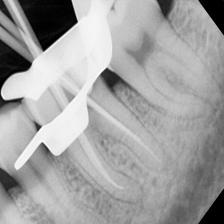
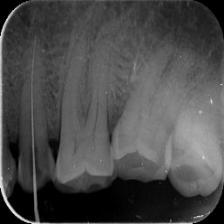
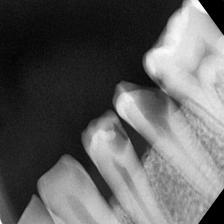
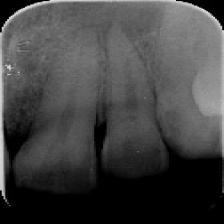
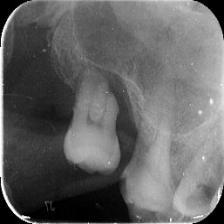
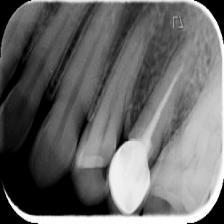
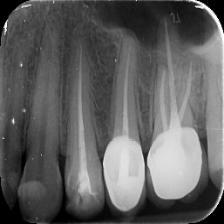
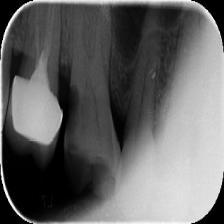

In [11]:
# @title Inspect training examples.
def render_inline(image, resize=(128, 128)):
  """Convert image into inline html."""
  image = Image.fromarray(image)
  image.resize(resize)
  with io.BytesIO() as buffer:
    image.save(buffer, format='jpeg')
    image_b64 = str(base64.b64encode(buffer.getvalue()), "utf-8")
    return f"data:image/jpeg;base64,{image_b64}"

def render_example(image, caption):
  image = ((image + 1)/2 * 255).astype(np.uint8)  # [-1,1] -> [0, 255]
  return f"""
    <div style="display: inline-flex; align-items: center; justify-content: center;">
        <img style="width:128px; height:128px;" src="{render_inline(image, resize=(64,64))}" />
        <p style="width:256px; margin:10px; font-size:small;">{html.escape(caption)}</p>
    </div>
    """

html_out = ""
for idx, example in zip(range(8), train_data_iterator()):
  caption = postprocess_tokens(example["text"])  # detokenize model input.
  caption = caption[len("Describe the status of the root canal treatment in various areas of the image. Indicate whether each area appears to be complete, incomplete, or in need of further treatment. If there are mixed cases, specify the status by mentioning the majority and minority areas accordingly. describe in en"):]        # strip prefix
  html_out += render_example(example["image"], caption)

print("Training examples")
display(HTML(html_out))

In [12]:
# @title Define the training step and evaluation loop.
#
# The main update_fn using simple SGD.
#
@functools.partial(jax.jit, donate_argnums=(0,))
def update_fn(params, batch, learning_rate):
  imgs, txts, mask_ar = batch["image"], batch["text"], batch["mask_ar"]

  def loss_fn(params):
    text_logits, _ = model.apply({"params": params}, imgs, txts[:, :-1], mask_ar[:, :-1], train=True)
    logp = jax.nn.log_softmax(text_logits, axis=-1)

    # The model takes as input txts[:, :-1] but the loss is defined as predicting
    # next tokens txts[:, 1:]. Additionally, mask_loss[:, 1:] indicates which tokens
    # are part of the loss (e.g. prefix and padded tokens are not included).
    mask_loss = batch["mask_loss"][:, 1:]
    targets = jax.nn.one_hot(txts[:, 1:], text_logits.shape[-1])

    # Compute the loss per example. i.e. the mean of per token pplx.
    # Since each example has a different number of tokens we normalize it.
    token_pplx = jnp.sum(logp * targets, axis=-1)  # sum across vocab_size.
    example_loss = -jnp.sum(token_pplx * mask_loss, axis=-1)  # sum across seq_len.
    example_loss /= jnp.clip(jnp.sum(mask_loss, -1), 1)  # weight by num of tokens.

    # batch_loss: mean of per example loss.
    return jnp.mean(example_loss)

  loss, grads = jax.value_and_grad(loss_fn)(params)

  # Apply gradients to trainable params using SGD.
  def apply_grad(param, gradient, trainable):
    if not trainable: return param
    return param - learning_rate * gradient

  params = jax.tree_util.tree_map(apply_grad, params, grads, trainable_mask)

  return params, loss

# Evaluation/inference loop.
def make_predictions(data_iterator, *, num_examples=None,
                     batch_size=4, seqlen=SEQLEN, sampler="greedy"):
  outputs = []
  while True:
    # Construct a list of examples in the batch.
    examples = []
    try:
      for _ in range(batch_size):
        examples.append(next(data_iterator))
        examples[-1]["_mask"] = np.array(True)  # Indicates true example.
    except StopIteration:
      if len(examples) == 0:
        return outputs

    # Not enough examples to complete a batch. Pad by repeating last example.
    while len(examples) % batch_size:
      examples.append(dict(examples[-1]))
      examples[-1]["_mask"] = np.array(False)  # Indicates padding example.

    # Convert list of examples into a dict of np.arrays and load onto devices.
    batch = jax.tree.map(lambda *x: np.stack(x), *examples)
    batch = big_vision.utils.reshard(batch, data_sharding)

    # Make model predictions
    tokens = decode({"params": params}, batch=batch,
                    max_decode_len=seqlen, sampler=sampler)

    # Fetch model predictions to device and detokenize.
    tokens, mask = jax.device_get((tokens, batch["_mask"]))
    tokens = tokens[mask]  # remove padding examples.
    responses = [postprocess_tokens(t) for t in tokens]

    # Append to html output.
    for example, response in zip(examples, responses):
      outputs.append((example["image"], response))
      if num_examples and len(outputs) >= num_examples:
        return outputs

step:  1/8000   lr: 0.00000   loss: 1.8397
Model predictions at step 1



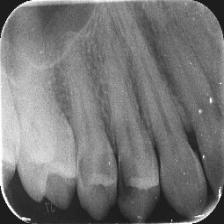
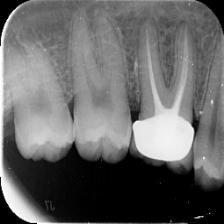
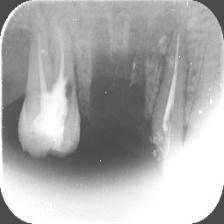
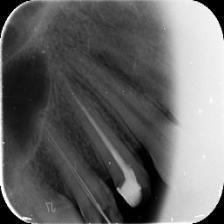
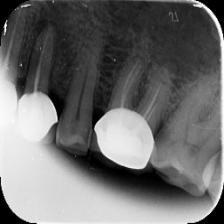
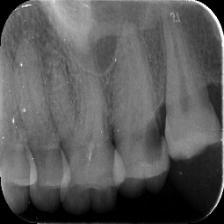
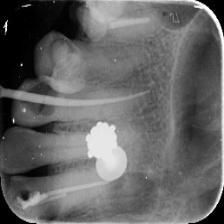
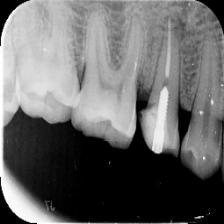

step:  2/8000   lr: 0.00000   loss: 1.9373
step:  3/8000   lr: 0.00000   loss: 1.5750
step:  4/8000   lr: 0.00001   loss: 1.5633
step:  5/8000   lr: 0.00001   loss: 1.4408
step:  6/8000   lr: 0.00001   loss: 1.7267
step:  7/8000   lr: 0.00001   loss: 1.5779
step:  8/8000   lr: 0.00001   loss: 1.4280
step:  9/8000   lr: 0.00001   loss: 1.3874
step: 10/8000   lr: 0.00001   loss: 1.2177
step: 11/8000   lr: 0.00001   loss: 1.3479
step: 12/8000   lr: 0.00002   loss: 1.7010
step: 13/8000   lr: 0.00002   loss: 1.2767
step: 14/8000   lr: 0.00002   loss: 1.6725
step: 15/8000   lr: 0.00002   loss: 1.2261
step: 16/8000   lr: 0.00002   loss: 1.3214
step: 17/8000   lr: 0.00002   loss: 0.9830
step: 18/8000   lr: 0.00002   loss: 1.5439
step: 19/8000   lr: 0.00002   loss: 1.3873
step: 20/8000   lr: 0.00003   loss: 1.5539
step: 21/8000   lr: 0.00003   loss: 1.7235
step: 22/8000   lr: 0.00003   loss: 1.1186
step: 23/8000   lr: 0.00003   loss: 1.8155
step: 24/8000   lr: 0.00003   loss: 1.9345
step: 25/80


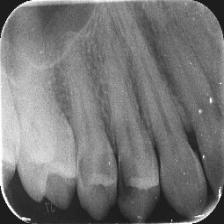
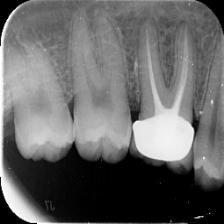
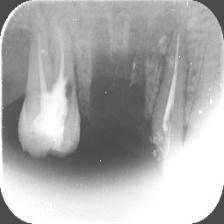
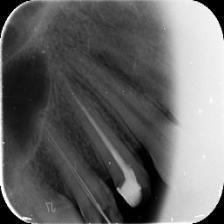
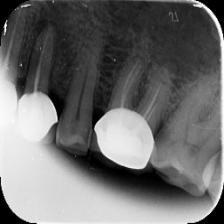
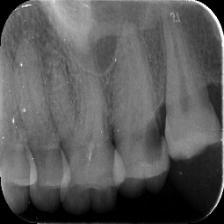
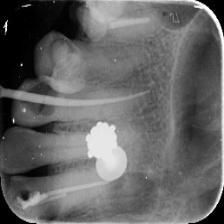
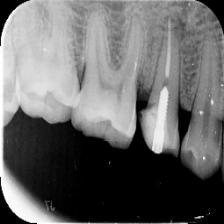

step: 501/8000   lr: 0.00063   loss: 0.1778
step: 502/8000   lr: 0.00063   loss: 0.7264
step: 503/8000   lr: 0.00063   loss: 0.2420
step: 504/8000   lr: 0.00063   loss: 0.1823
step: 505/8000   lr: 0.00063   loss: 0.1898
step: 506/8000   lr: 0.00063   loss: 0.6631
step: 507/8000   lr: 0.00063   loss: 0.1762
step: 508/8000   lr: 0.00064   loss: 0.1850
step: 509/8000   lr: 0.00064   loss: 0.2633
step: 510/8000   lr: 0.00064   loss: 0.4250
step: 511/8000   lr: 0.00064   loss: 0.5098
step: 512/8000   lr: 0.00064   loss: 0.2083
step: 513/8000   lr: 0.00064   loss: 0.4714
step: 514/8000   lr: 0.00064   loss: 0.5309
step: 515/8000   lr: 0.00064   loss: 0.0948
step: 516/8000   lr: 0.00065   loss: 0.3668
step: 517/8000   lr: 0.00065   loss: 0.1862
step: 518/8000   lr: 0.00065   loss: 0.3056
step: 519/8000   lr: 0.00065   loss: 0.3336
step: 520/8000   lr: 0.00065   loss: 0.0865
step: 521/8000   lr: 0.00065   loss: 0.1112
step: 522/8000   lr: 0.00065   loss: 0.2071
step: 523/8000   lr: 0.00065   l


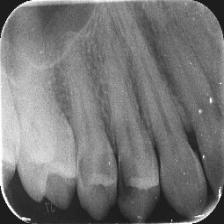
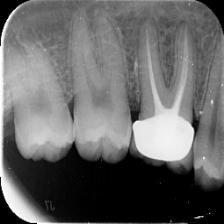
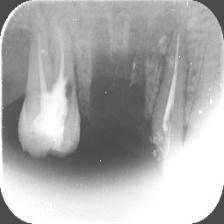
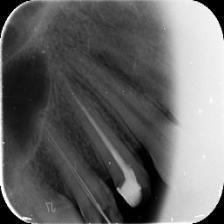
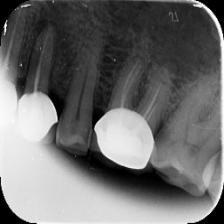
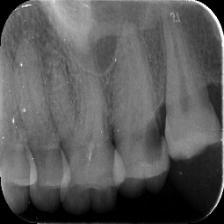
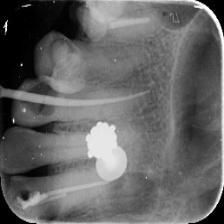
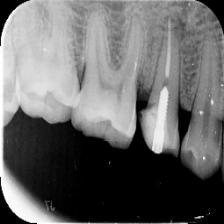

step: 1001/8000   lr: 0.00100   loss: 0.0654
step: 1002/8000   lr: 0.00100   loss: 0.1401
step: 1003/8000   lr: 0.00100   loss: 0.0880
step: 1004/8000   lr: 0.00100   loss: 0.2020
step: 1005/8000   lr: 0.00100   loss: 0.1152
step: 1006/8000   lr: 0.00100   loss: 0.0655
step: 1007/8000   lr: 0.00100   loss: 0.1638
step: 1008/8000   lr: 0.00100   loss: 0.2750
step: 1009/8000   lr: 0.00100   loss: 0.1325
step: 1010/8000   lr: 0.00100   loss: 0.0743
step: 1011/8000   lr: 0.00100   loss: 0.3214
step: 1012/8000   lr: 0.00100   loss: 0.2028
step: 1013/8000   lr: 0.00100   loss: 0.2330
step: 1014/8000   lr: 0.00100   loss: 0.2013
step: 1015/8000   lr: 0.00100   loss: 0.1180
step: 1016/8000   lr: 0.00100   loss: 0.3350
step: 1017/8000   lr: 0.00100   loss: 0.0679
step: 1018/8000   lr: 0.00100   loss: 0.0558
step: 1019/8000   lr: 0.00100   loss: 0.1776
step: 1020/8000   lr: 0.00100   loss: 0.1059
step: 1021/8000   lr: 0.00100   loss: 0.1293
step: 1022/8000   lr: 0.00100   loss: 0.1009
step: 1023


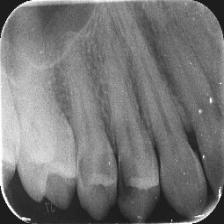
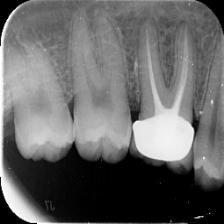
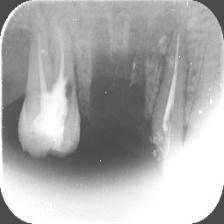
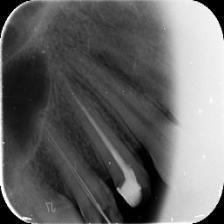
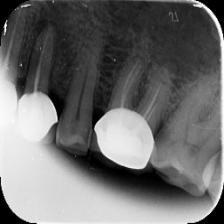
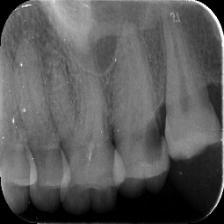
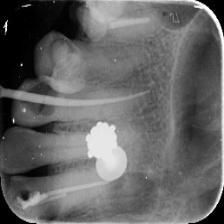
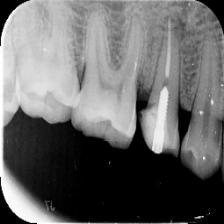

step: 1501/8000   lr: 0.00098   loss: 0.0751
step: 1502/8000   lr: 0.00098   loss: 0.0719
step: 1503/8000   lr: 0.00098   loss: 0.0433
step: 1504/8000   lr: 0.00098   loss: 0.0988
step: 1505/8000   lr: 0.00098   loss: 0.1002
step: 1506/8000   lr: 0.00098   loss: 0.0917
step: 1507/8000   lr: 0.00098   loss: 0.0702
step: 1508/8000   lr: 0.00098   loss: 0.0664
step: 1509/8000   lr: 0.00098   loss: 0.0660
step: 1510/8000   lr: 0.00098   loss: 0.0682
step: 1511/8000   lr: 0.00098   loss: 0.0695
step: 1512/8000   lr: 0.00098   loss: 0.0547
step: 1513/8000   lr: 0.00098   loss: 0.0783
step: 1514/8000   lr: 0.00098   loss: 0.0505
step: 1515/8000   lr: 0.00098   loss: 0.1656
step: 1516/8000   lr: 0.00098   loss: 0.0259
step: 1517/8000   lr: 0.00098   loss: 0.0536
step: 1518/8000   lr: 0.00098   loss: 0.1591
step: 1519/8000   lr: 0.00098   loss: 0.1069
step: 1520/8000   lr: 0.00098   loss: 0.0741
step: 1521/8000   lr: 0.00098   loss: 0.0333
step: 1522/8000   lr: 0.00098   loss: 0.0984
step: 1523


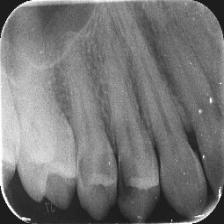
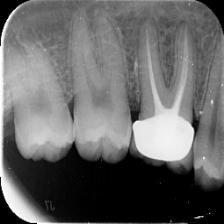
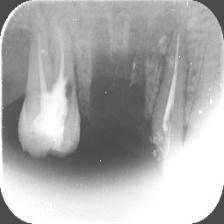
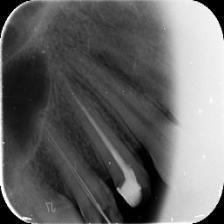
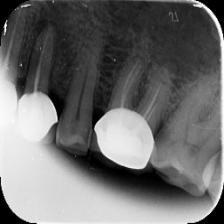
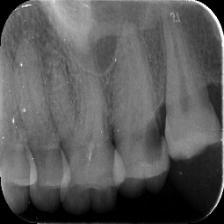
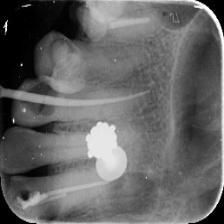
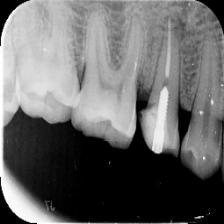

step: 2001/8000   lr: 0.00093   loss: 0.0545
step: 2002/8000   lr: 0.00093   loss: 0.0426
step: 2003/8000   lr: 0.00093   loss: 0.0314
step: 2004/8000   lr: 0.00093   loss: 0.0350
step: 2005/8000   lr: 0.00093   loss: 0.0083
step: 2006/8000   lr: 0.00093   loss: 0.0242
step: 2007/8000   lr: 0.00093   loss: 0.0399
step: 2008/8000   lr: 0.00093   loss: 0.0182
step: 2009/8000   lr: 0.00093   loss: 0.0363
step: 2010/8000   lr: 0.00093   loss: 0.0799
step: 2011/8000   lr: 0.00093   loss: 0.0552
step: 2012/8000   lr: 0.00093   loss: 0.0559
step: 2013/8000   lr: 0.00093   loss: 0.0180
step: 2014/8000   lr: 0.00093   loss: 0.0295
step: 2015/8000   lr: 0.00093   loss: 0.0309
step: 2016/8000   lr: 0.00093   loss: 0.0590
step: 2017/8000   lr: 0.00093   loss: 0.0349
step: 2018/8000   lr: 0.00093   loss: 0.0313
step: 2019/8000   lr: 0.00093   loss: 0.0685
step: 2020/8000   lr: 0.00093   loss: 0.1032
step: 2021/8000   lr: 0.00093   loss: 0.0327
step: 2022/8000   lr: 0.00093   loss: 0.0496
step: 2023


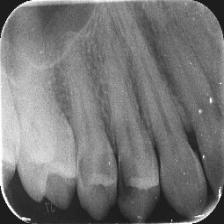
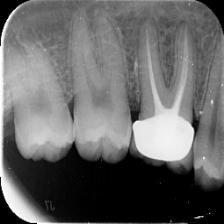
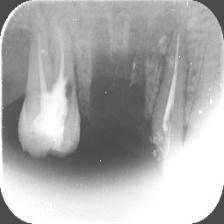
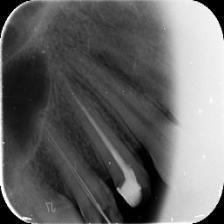
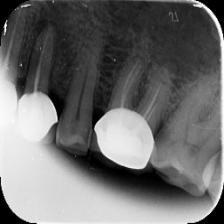
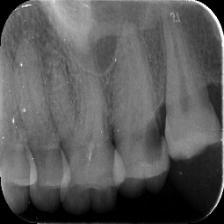
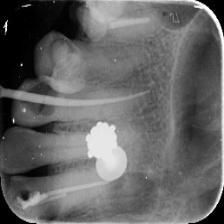
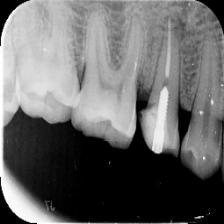

step: 2501/8000   lr: 0.00087   loss: 0.0076
step: 2502/8000   lr: 0.00087   loss: 0.0176
step: 2503/8000   lr: 0.00087   loss: 0.0207
step: 2504/8000   lr: 0.00087   loss: 0.0174
step: 2505/8000   lr: 0.00087   loss: 0.0056
step: 2506/8000   lr: 0.00087   loss: 0.0315
step: 2507/8000   lr: 0.00087   loss: 0.0263
step: 2508/8000   lr: 0.00087   loss: 0.1185
step: 2509/8000   lr: 0.00087   loss: 0.0263
step: 2510/8000   lr: 0.00087   loss: 0.1121
step: 2511/8000   lr: 0.00087   loss: 0.0109
step: 2512/8000   lr: 0.00087   loss: 0.0140
step: 2513/8000   lr: 0.00087   loss: 0.0454
step: 2514/8000   lr: 0.00087   loss: 0.0144
step: 2515/8000   lr: 0.00087   loss: 0.0144
step: 2516/8000   lr: 0.00087   loss: 0.0021
step: 2517/8000   lr: 0.00087   loss: 0.0727
step: 2518/8000   lr: 0.00087   loss: 0.0121
step: 2519/8000   lr: 0.00087   loss: 0.0069
step: 2520/8000   lr: 0.00087   loss: 0.0159
step: 2521/8000   lr: 0.00087   loss: 0.0154
step: 2522/8000   lr: 0.00087   loss: 0.0030
step: 2523


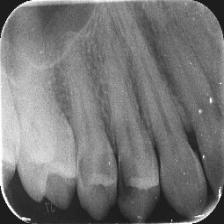
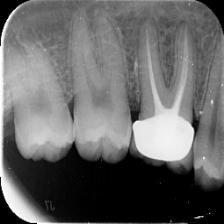
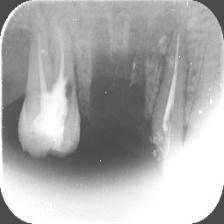
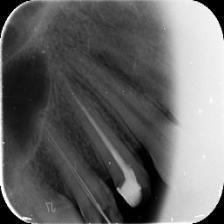
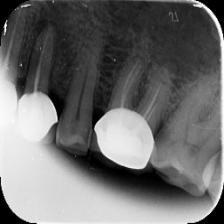
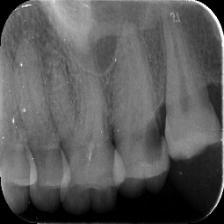
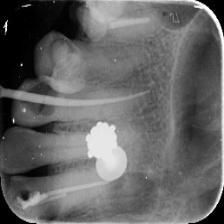
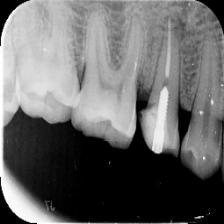

step: 3001/8000   lr: 0.00079   loss: 0.0103
step: 3002/8000   lr: 0.00079   loss: 0.0031
step: 3003/8000   lr: 0.00079   loss: 0.0177
step: 3004/8000   lr: 0.00079   loss: 0.0083
step: 3005/8000   lr: 0.00079   loss: 0.0177
step: 3006/8000   lr: 0.00079   loss: 0.0141
step: 3007/8000   lr: 0.00079   loss: 0.0091
step: 3008/8000   lr: 0.00079   loss: 0.0065
step: 3009/8000   lr: 0.00079   loss: 0.0030
step: 3010/8000   lr: 0.00079   loss: 0.0013
step: 3011/8000   lr: 0.00078   loss: 0.0039
step: 3012/8000   lr: 0.00078   loss: 0.0034
step: 3013/8000   lr: 0.00078   loss: 0.0144
step: 3014/8000   lr: 0.00078   loss: 0.0134
step: 3015/8000   lr: 0.00078   loss: 0.0036
step: 3016/8000   lr: 0.00078   loss: 0.0069
step: 3017/8000   lr: 0.00078   loss: 0.0038
step: 3018/8000   lr: 0.00078   loss: 0.0039
step: 3019/8000   lr: 0.00078   loss: 0.0074
step: 3020/8000   lr: 0.00078   loss: 0.0044
step: 3021/8000   lr: 0.00078   loss: 0.0841
step: 3022/8000   lr: 0.00078   loss: 0.0035
step: 3023


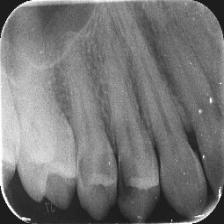
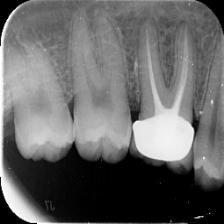
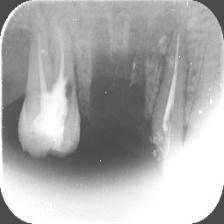
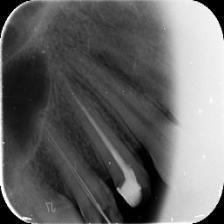
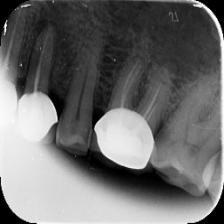
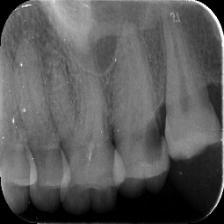
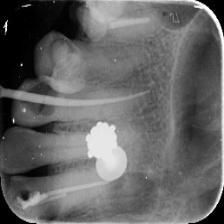
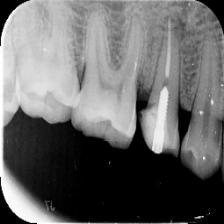

step: 3501/8000   lr: 0.00069   loss: 0.0003
step: 3502/8000   lr: 0.00069   loss: 0.0008
step: 3503/8000   lr: 0.00069   loss: 0.0023
step: 3504/8000   lr: 0.00069   loss: 0.0048
step: 3505/8000   lr: 0.00069   loss: 0.0027
step: 3506/8000   lr: 0.00069   loss: 0.0031
step: 3507/8000   lr: 0.00069   loss: 0.0034
step: 3508/8000   lr: 0.00069   loss: 0.0029
step: 3509/8000   lr: 0.00069   loss: 0.0008
step: 3510/8000   lr: 0.00069   loss: 0.0021
step: 3511/8000   lr: 0.00069   loss: 0.0063
step: 3512/8000   lr: 0.00069   loss: 0.0028
step: 3513/8000   lr: 0.00069   loss: 0.0016
step: 3514/8000   lr: 0.00069   loss: 0.0008
step: 3515/8000   lr: 0.00069   loss: 0.0013
step: 3516/8000   lr: 0.00069   loss: 0.0016
step: 3517/8000   lr: 0.00069   loss: 0.0017
step: 3518/8000   lr: 0.00069   loss: 0.0046
step: 3519/8000   lr: 0.00069   loss: 0.0025
step: 3520/8000   lr: 0.00069   loss: 0.0031
step: 3521/8000   lr: 0.00069   loss: 0.0012
step: 3522/8000   lr: 0.00069   loss: 0.0068
step: 3523


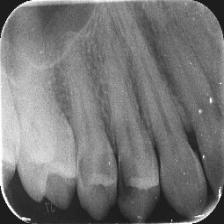
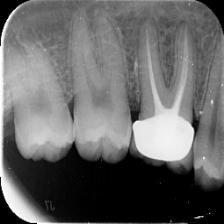
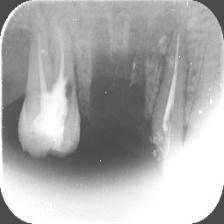
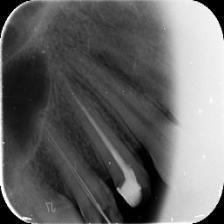
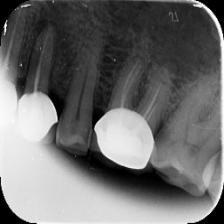
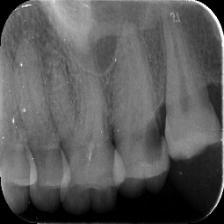
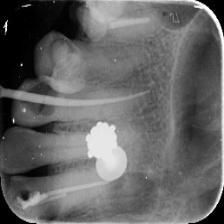
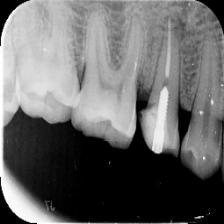

step: 4001/8000   lr: 0.00059   loss: 0.0015
step: 4002/8000   lr: 0.00059   loss: 0.0011
step: 4003/8000   lr: 0.00059   loss: 0.0027
step: 4004/8000   lr: 0.00059   loss: 0.0030
step: 4005/8000   lr: 0.00059   loss: 0.0022
step: 4006/8000   lr: 0.00059   loss: 0.0009
step: 4007/8000   lr: 0.00059   loss: 0.0059
step: 4008/8000   lr: 0.00059   loss: 0.0021
step: 4009/8000   lr: 0.00058   loss: 0.0052
step: 4010/8000   lr: 0.00058   loss: 0.0016
step: 4011/8000   lr: 0.00058   loss: 0.0010
step: 4012/8000   lr: 0.00058   loss: 0.0024
step: 4013/8000   lr: 0.00058   loss: 0.0021
step: 4014/8000   lr: 0.00058   loss: 0.0049
step: 4015/8000   lr: 0.00058   loss: 0.0020
step: 4016/8000   lr: 0.00058   loss: 0.0013
step: 4017/8000   lr: 0.00058   loss: 0.0024
step: 4018/8000   lr: 0.00058   loss: 0.0030
step: 4019/8000   lr: 0.00058   loss: 0.0012
step: 4020/8000   lr: 0.00058   loss: 0.0012
step: 4021/8000   lr: 0.00058   loss: 0.0016
step: 4022/8000   lr: 0.00058   loss: 0.0005
step: 4023


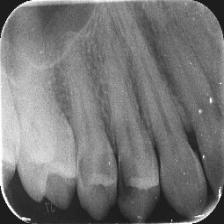
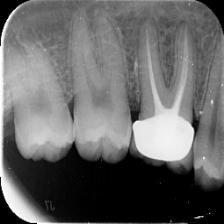
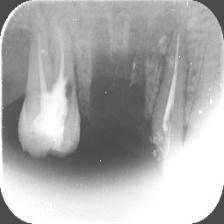
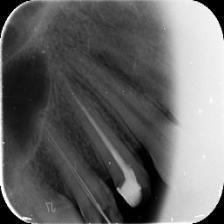
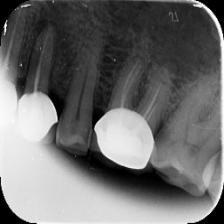
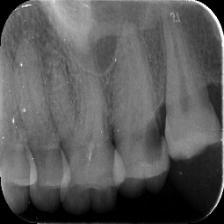
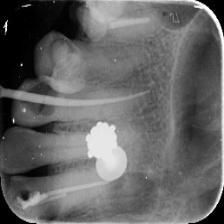
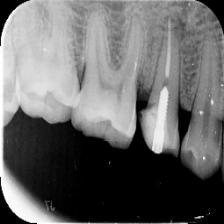

step: 4501/8000   lr: 0.00048   loss: 0.0016
step: 4502/8000   lr: 0.00048   loss: 0.0014
step: 4503/8000   lr: 0.00048   loss: 0.0013
step: 4504/8000   lr: 0.00048   loss: 0.0024
step: 4505/8000   lr: 0.00048   loss: 0.0022
step: 4506/8000   lr: 0.00048   loss: 0.0014
step: 4507/8000   lr: 0.00048   loss: 0.0014
step: 4508/8000   lr: 0.00048   loss: 0.0009
step: 4509/8000   lr: 0.00048   loss: 0.0010
step: 4510/8000   lr: 0.00048   loss: 0.0006
step: 4511/8000   lr: 0.00048   loss: 0.0005
step: 4512/8000   lr: 0.00048   loss: 0.0007
step: 4513/8000   lr: 0.00048   loss: 0.0017
step: 4514/8000   lr: 0.00048   loss: 0.0008
step: 4515/8000   lr: 0.00048   loss: 0.0007
step: 4516/8000   lr: 0.00047   loss: 0.0007
step: 4517/8000   lr: 0.00047   loss: 0.0018
step: 4518/8000   lr: 0.00047   loss: 0.0021
step: 4519/8000   lr: 0.00047   loss: 0.0007
step: 4520/8000   lr: 0.00047   loss: 0.0017
step: 4521/8000   lr: 0.00047   loss: 0.0006
step: 4522/8000   lr: 0.00047   loss: 0.0030
step: 4523


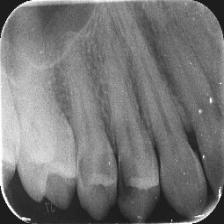
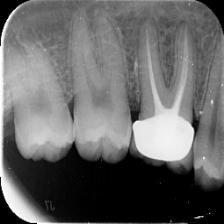
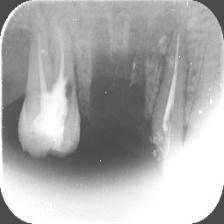
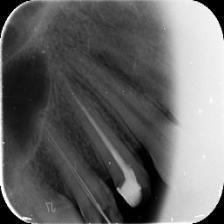
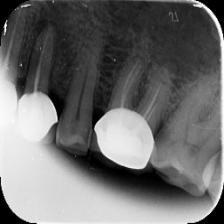
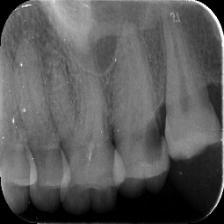
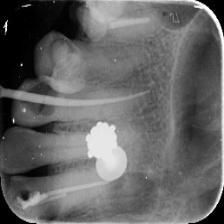
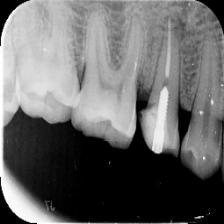

step: 5001/8000   lr: 0.00037   loss: 0.0003
step: 5002/8000   lr: 0.00037   loss: 0.0016
step: 5003/8000   lr: 0.00037   loss: 0.0007
step: 5004/8000   lr: 0.00037   loss: 0.0008
step: 5005/8000   lr: 0.00037   loss: 0.0009
step: 5006/8000   lr: 0.00037   loss: 0.0010
step: 5007/8000   lr: 0.00037   loss: 0.0008
step: 5008/8000   lr: 0.00037   loss: 0.0003
step: 5009/8000   lr: 0.00037   loss: 0.0027
step: 5010/8000   lr: 0.00037   loss: 0.0012
step: 5011/8000   lr: 0.00037   loss: 0.0021
step: 5012/8000   lr: 0.00037   loss: 0.0021
step: 5013/8000   lr: 0.00037   loss: 0.0012
step: 5014/8000   lr: 0.00037   loss: 0.0008
step: 5015/8000   lr: 0.00037   loss: 0.0021
step: 5016/8000   lr: 0.00037   loss: 0.0010
step: 5017/8000   lr: 0.00037   loss: 0.0009
step: 5018/8000   lr: 0.00037   loss: 0.0006
step: 5019/8000   lr: 0.00037   loss: 0.0005
step: 5020/8000   lr: 0.00037   loss: 0.0018
step: 5021/8000   lr: 0.00037   loss: 0.0016
step: 5022/8000   lr: 0.00037   loss: 0.0007
step: 5023


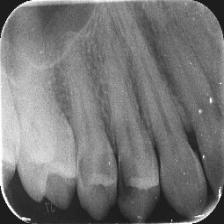
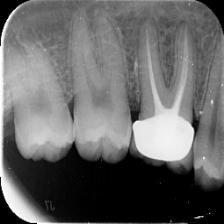
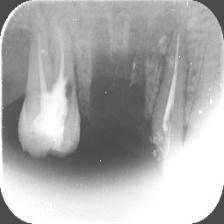
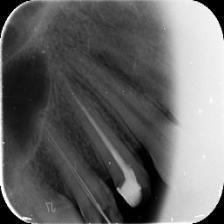
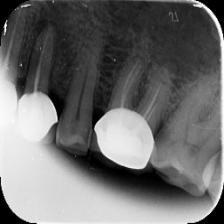
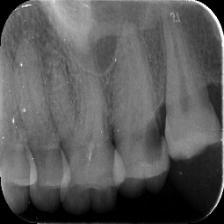
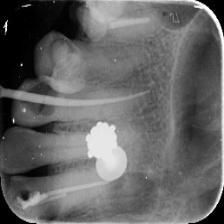
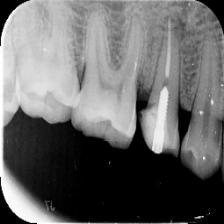

step: 5501/8000   lr: 0.00027   loss: 0.0013
step: 5502/8000   lr: 0.00027   loss: 0.0012
step: 5503/8000   lr: 0.00027   loss: 0.0011
step: 5504/8000   lr: 0.00027   loss: 0.0008
step: 5505/8000   lr: 0.00027   loss: 0.0008
step: 5506/8000   lr: 0.00027   loss: 0.0007
step: 5507/8000   lr: 0.00027   loss: 0.0002
step: 5508/8000   lr: 0.00027   loss: 0.0005
step: 5509/8000   lr: 0.00027   loss: 0.0014
step: 5510/8000   lr: 0.00027   loss: 0.0008
step: 5511/8000   lr: 0.00027   loss: 0.0037
step: 5512/8000   lr: 0.00027   loss: 0.0005
step: 5513/8000   lr: 0.00027   loss: 0.0016
step: 5514/8000   lr: 0.00027   loss: 0.0017
step: 5515/8000   lr: 0.00027   loss: 0.0013
step: 5516/8000   lr: 0.00027   loss: 0.0007
step: 5517/8000   lr: 0.00027   loss: 0.0014
step: 5518/8000   lr: 0.00027   loss: 0.0004
step: 5519/8000   lr: 0.00027   loss: 0.0025
step: 5520/8000   lr: 0.00027   loss: 0.0006
step: 5521/8000   lr: 0.00027   loss: 0.0005
step: 5522/8000   lr: 0.00027   loss: 0.0014
step: 5523


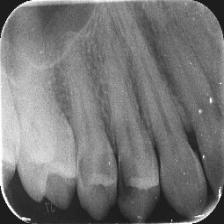
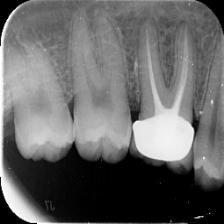
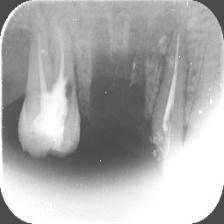
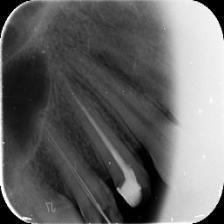
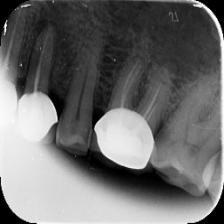
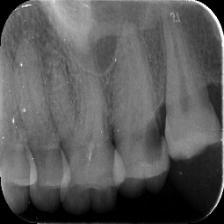
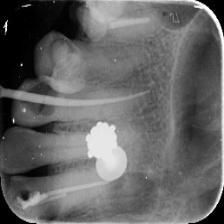
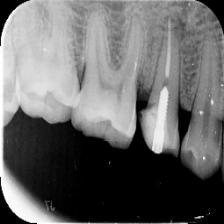

step: 6001/8000   lr: 0.00018   loss: 0.0005
step: 6002/8000   lr: 0.00018   loss: 0.0006
step: 6003/8000   lr: 0.00018   loss: 0.0007
step: 6004/8000   lr: 0.00018   loss: 0.0007
step: 6005/8000   lr: 0.00018   loss: 0.0010
step: 6006/8000   lr: 0.00018   loss: 0.0007
step: 6007/8000   lr: 0.00018   loss: 0.0007
step: 6008/8000   lr: 0.00018   loss: 0.0011
step: 6009/8000   lr: 0.00018   loss: 0.0008
step: 6010/8000   lr: 0.00018   loss: 0.0004
step: 6011/8000   lr: 0.00018   loss: 0.0011
step: 6012/8000   lr: 0.00018   loss: 0.0019
step: 6013/8000   lr: 0.00018   loss: 0.0003
step: 6014/8000   lr: 0.00018   loss: 0.0018
step: 6015/8000   lr: 0.00018   loss: 0.0007
step: 6016/8000   lr: 0.00018   loss: 0.0008
step: 6017/8000   lr: 0.00018   loss: 0.0009
step: 6018/8000   lr: 0.00018   loss: 0.0004
step: 6019/8000   lr: 0.00018   loss: 0.0002
step: 6020/8000   lr: 0.00018   loss: 0.0003
step: 6021/8000   lr: 0.00018   loss: 0.0008
step: 6022/8000   lr: 0.00018   loss: 0.0007
step: 6023


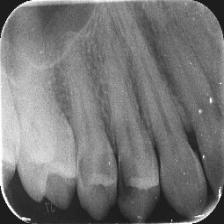
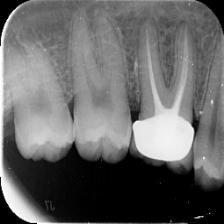
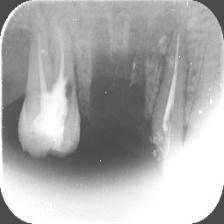
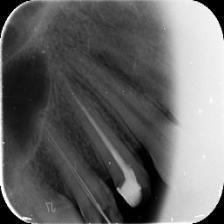
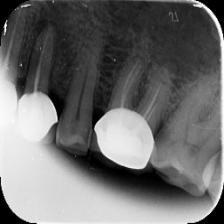
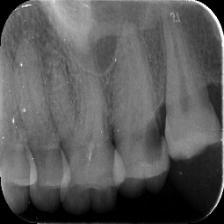
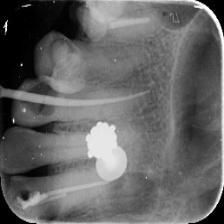
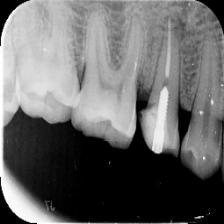

step: 6501/8000   lr: 0.00010   loss: 0.0005
step: 6502/8000   lr: 0.00010   loss: 0.0015
step: 6503/8000   lr: 0.00010   loss: 0.0006
step: 6504/8000   lr: 0.00010   loss: 0.0009
step: 6505/8000   lr: 0.00010   loss: 0.0002
step: 6506/8000   lr: 0.00010   loss: 0.0008
step: 6507/8000   lr: 0.00010   loss: 0.0006
step: 6508/8000   lr: 0.00010   loss: 0.0009
step: 6509/8000   lr: 0.00010   loss: 0.0018
step: 6510/8000   lr: 0.00010   loss: 0.0004
step: 6511/8000   lr: 0.00010   loss: 0.0006
step: 6512/8000   lr: 0.00010   loss: 0.0022
step: 6513/8000   lr: 0.00010   loss: 0.0005
step: 6514/8000   lr: 0.00010   loss: 0.0010
step: 6515/8000   lr: 0.00010   loss: 0.0016
step: 6516/8000   lr: 0.00010   loss: 0.0003
step: 6517/8000   lr: 0.00010   loss: 0.0007
step: 6518/8000   lr: 0.00010   loss: 0.0004
step: 6519/8000   lr: 0.00010   loss: 0.0010
step: 6520/8000   lr: 0.00010   loss: 0.0017
step: 6521/8000   lr: 0.00010   loss: 0.0009
step: 6522/8000   lr: 0.00010   loss: 0.0016
step: 6523


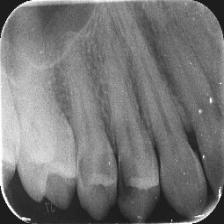
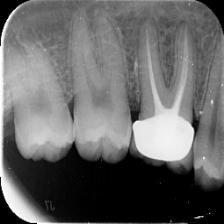
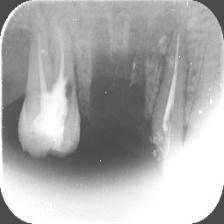
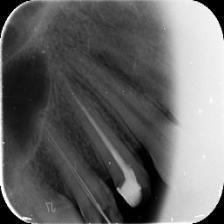
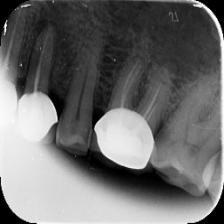
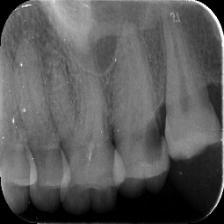
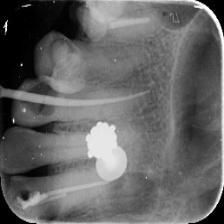
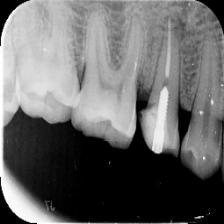

step: 7001/8000   lr: 0.00005   loss: 0.0004
step: 7002/8000   lr: 0.00005   loss: 0.0009
step: 7003/8000   lr: 0.00005   loss: 0.0007
step: 7004/8000   lr: 0.00005   loss: 0.0013
step: 7005/8000   lr: 0.00005   loss: 0.0017
step: 7006/8000   lr: 0.00005   loss: 0.0008
step: 7007/8000   lr: 0.00005   loss: 0.0002
step: 7008/8000   lr: 0.00005   loss: 0.0014
step: 7009/8000   lr: 0.00005   loss: 0.0005
step: 7010/8000   lr: 0.00005   loss: 0.0006
step: 7011/8000   lr: 0.00005   loss: 0.0014
step: 7012/8000   lr: 0.00005   loss: 0.0004
step: 7013/8000   lr: 0.00005   loss: 0.0011
step: 7014/8000   lr: 0.00005   loss: 0.0007
step: 7015/8000   lr: 0.00005   loss: 0.0016
step: 7016/8000   lr: 0.00005   loss: 0.0005
step: 7017/8000   lr: 0.00005   loss: 0.0007
step: 7018/8000   lr: 0.00005   loss: 0.0006
step: 7019/8000   lr: 0.00005   loss: 0.0007
step: 7020/8000   lr: 0.00005   loss: 0.0014
step: 7021/8000   lr: 0.00005   loss: 0.0003
step: 7022/8000   lr: 0.00004   loss: 0.0011
step: 7023


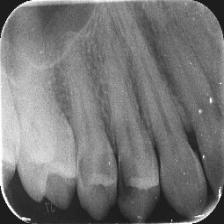
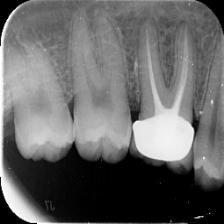
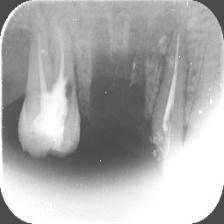
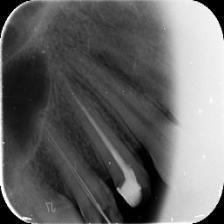
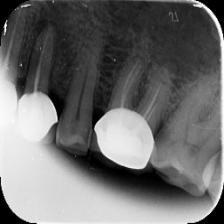
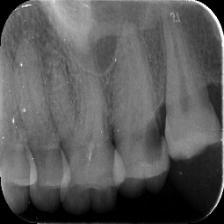
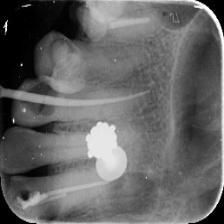
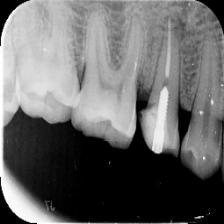

step: 7501/8000   lr: 0.00001   loss: 0.0034
step: 7502/8000   lr: 0.00001   loss: 0.0009
step: 7503/8000   lr: 0.00001   loss: 0.0018
step: 7504/8000   lr: 0.00001   loss: 0.0004
step: 7505/8000   lr: 0.00001   loss: 0.0004
step: 7506/8000   lr: 0.00001   loss: 0.0004
step: 7507/8000   lr: 0.00001   loss: 0.0007
step: 7508/8000   lr: 0.00001   loss: 0.0006
step: 7509/8000   lr: 0.00001   loss: 0.0013
step: 7510/8000   lr: 0.00001   loss: 0.0005
step: 7511/8000   lr: 0.00001   loss: 0.0008
step: 7512/8000   lr: 0.00001   loss: 0.0005
step: 7513/8000   lr: 0.00001   loss: 0.0009
step: 7514/8000   lr: 0.00001   loss: 0.0005
step: 7515/8000   lr: 0.00001   loss: 0.0004
step: 7516/8000   lr: 0.00001   loss: 0.0022
step: 7517/8000   lr: 0.00001   loss: 0.0006
step: 7518/8000   lr: 0.00001   loss: 0.0012
step: 7519/8000   lr: 0.00001   loss: 0.0005
step: 7520/8000   lr: 0.00001   loss: 0.0006
step: 7521/8000   lr: 0.00001   loss: 0.0008
step: 7522/8000   lr: 0.00001   loss: 0.0005
step: 7523


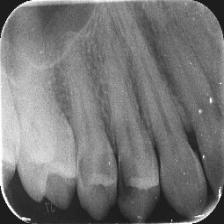
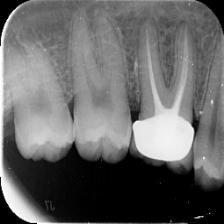
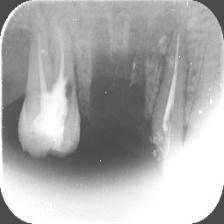
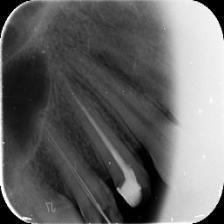
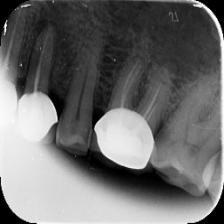
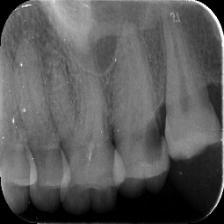
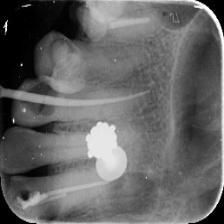
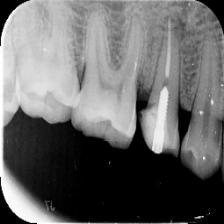

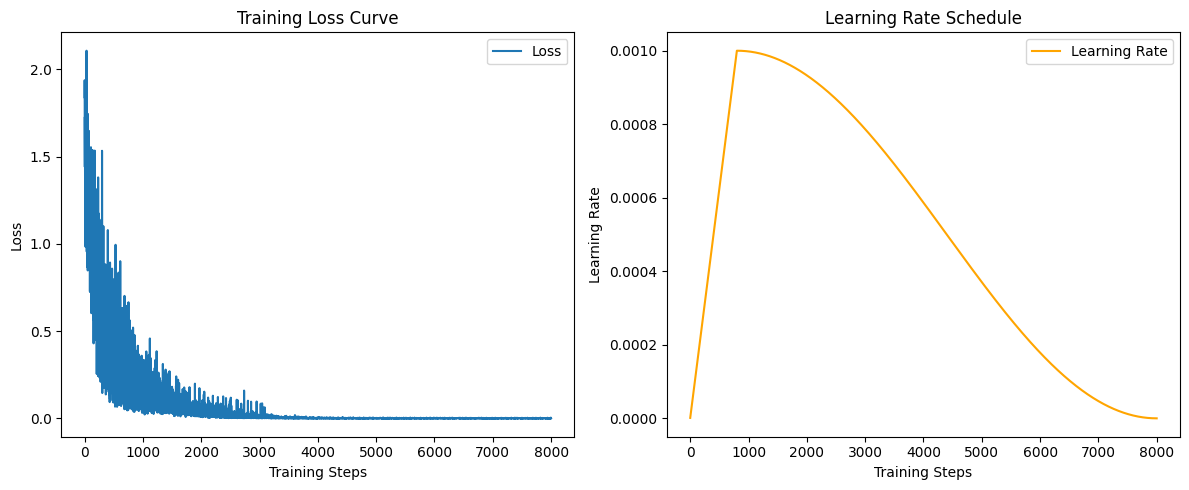

In [13]:
import matplotlib.pyplot as plt

# Initialize lists to store learning rates and losses
learning_rates = []
losses = []

BATCH_SIZE = 2
TRAIN_EXAMPLES = 16000
LEARNING_RATE = 0.001

TRAIN_STEPS = TRAIN_EXAMPLES // BATCH_SIZE
EVAL_STEPS = TRAIN_STEPS // 16

train_data_it = train_data_iterator()

sched_fn = big_vision.utils.create_learning_rate_schedule(
    total_steps=TRAIN_STEPS+1, base=LEARNING_RATE,
    decay_type="cosine", warmup_percent=0.10)

for step in range(1, TRAIN_STEPS+1):
    # Make list of N training examples
    examples = [next(train_data_it) for _ in range(BATCH_SIZE)]

    # Convert list of examples into a dict of np.arrays and load onto devices
    batch = jax.tree.map(lambda *x: np.stack(x), *examples)
    batch = big_vision.utils.reshard(batch, data_sharding)

    # Training step and report training loss
    learning_rate = sched_fn(step)
    params, loss = update_fn(params, batch, learning_rate)

    # Store learning rate and loss for plotting later
    learning_rates.append(learning_rate)
    loss = jax.device_get(loss)
    losses.append(loss)

    print(f"step: {step:2d}/{TRAIN_STEPS:2d}   lr: {learning_rate:.5f}   loss: {loss:.4f}")

    if step == 1 or (step % EVAL_STEPS) == 0:
        print(f"Model predictions at step {step}")
        html_out = ""
        for image, caption in make_predictions(
            validation_data_iterator(), num_examples=8, batch_size=1):
            html_out += render_example(image, caption)
        display(HTML(html_out))

# Plot the loss curve and learning rate schedule
plt.figure(figsize=(12, 5))

# Plot loss curve
plt.subplot(1, 2, 1)
plt.plot(losses, label='Loss')
plt.title('Training Loss Curve')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.legend()

# Plot learning rate schedule
plt.subplot(1, 2, 2)
plt.plot(learning_rates, label='Learning Rate', color='orange')
plt.title('Learning Rate Schedule')
plt.xlabel('Training Steps')
plt.ylabel('Learning Rate')
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
# Install all required packages
!pip install scikit-learn nltk rouge-score git+https://github.com/salaniz/pycocoevalcap.git

# Download necessary NLTK data packages for BLEU and METEOR scores
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  Cloning https://github.com/salaniz/pycocoevalcap.git to /tmp/pip-req-build-pmlzwexz
  Running command git clone --filter=blob:none --quiet https://github.com/salaniz/pycocoevalcap.git /tmp/pip-req-build-pmlzwexz
  Resolved https://github.com/salaniz/pycocoevalcap.git to commit a24f74c408c918f1f4ec34e9514bc8a76ce41ffd
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... - done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.8/427.8 kB 8.0 MB/s eta 0:00:00
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=09d56b431ffa07b2fcadcd5ce55db5720946f3ea8ee980dadc808954a2860f6a
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
  Created wheel for pycocoevalcap: filename=pycocoevalcap-1.2-py3-none-any.whl size=104312246 sha256=9f4da15a4bde1ff60072e5f2b27bd6b32ccf7666d039de0f1e7e93a20e1e22d9
  Stored in directory: /tmp/pip-ephem-wheel-cache-dsrd32kf/wheels/57/de/9f/7aa9a

True

Model predictions



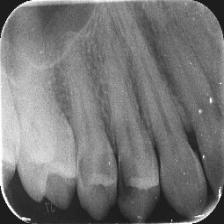
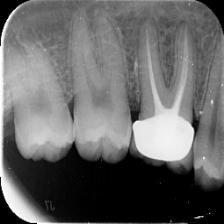
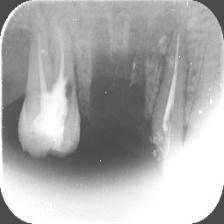
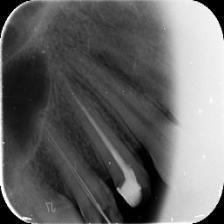
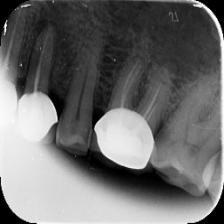
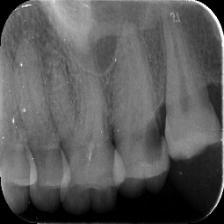
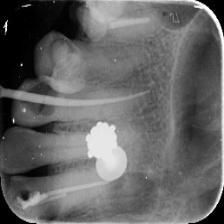
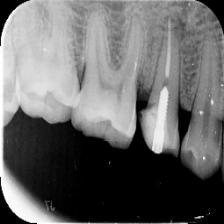
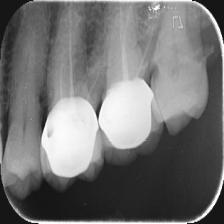
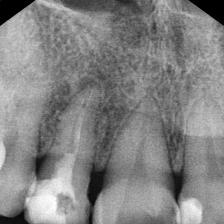
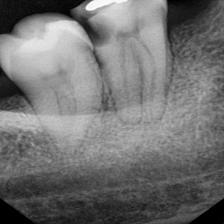
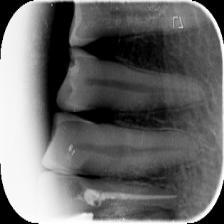
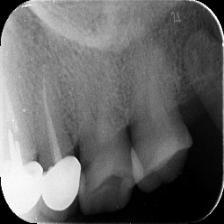
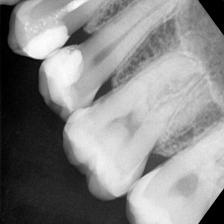
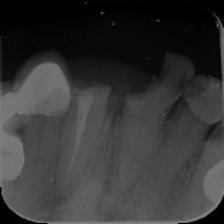
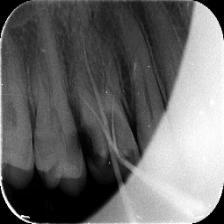
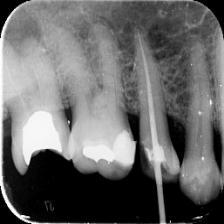
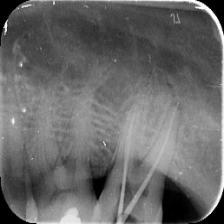
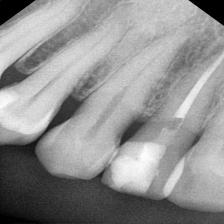
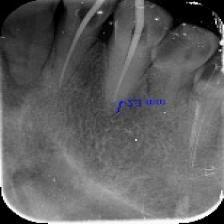
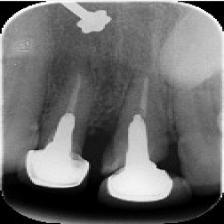
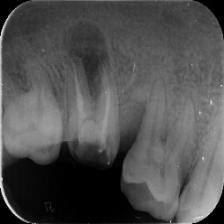
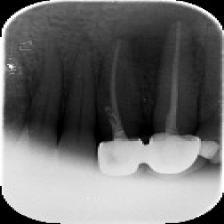
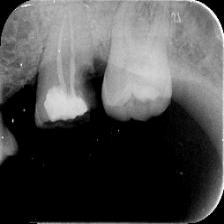
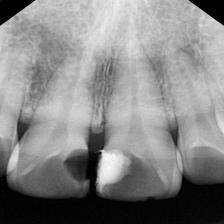
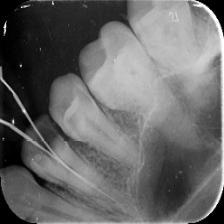
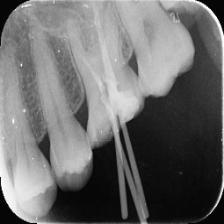
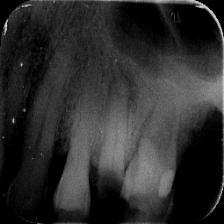
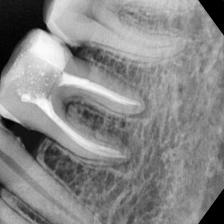
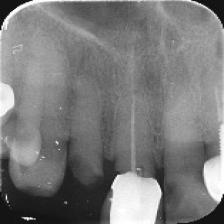
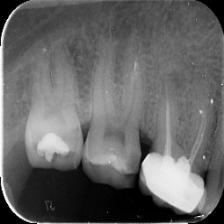
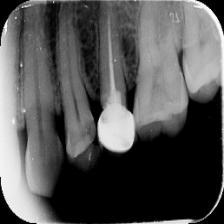
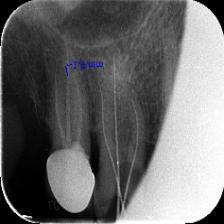
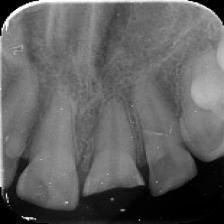
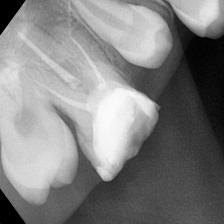
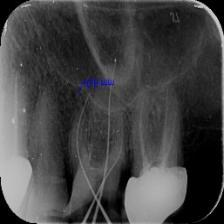
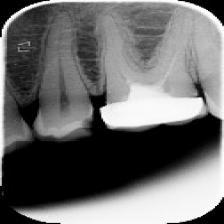
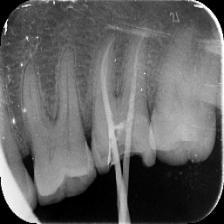
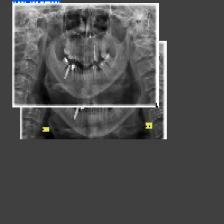
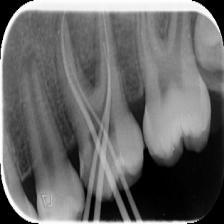
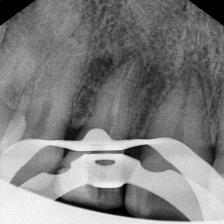
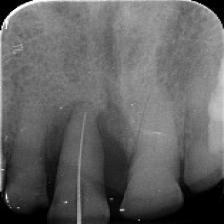
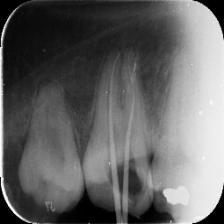
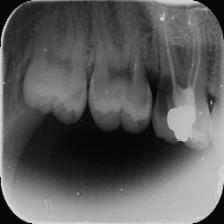
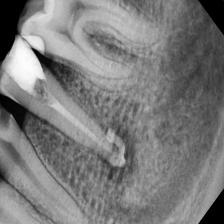
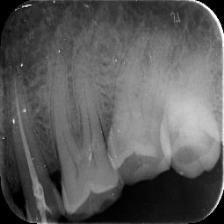
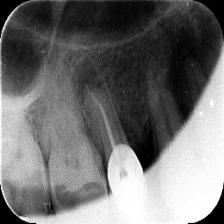
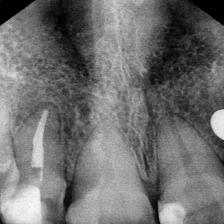
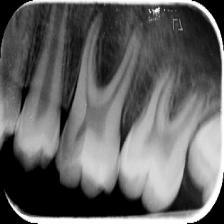
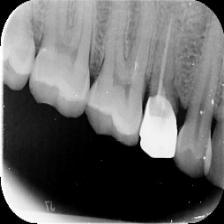
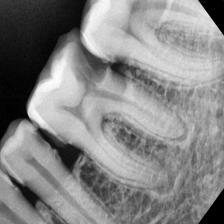
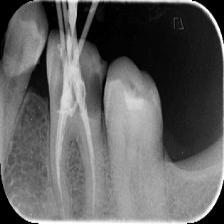
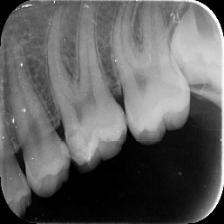
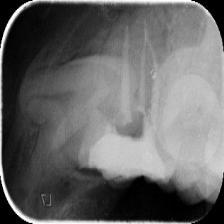
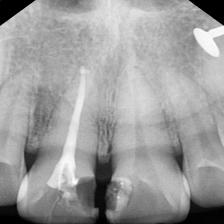
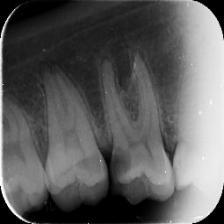
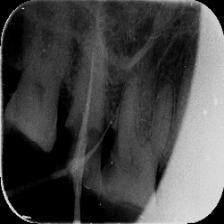
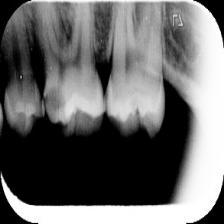
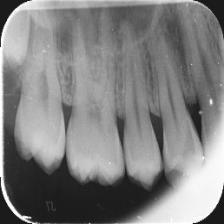
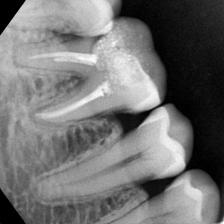
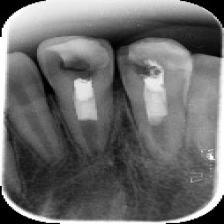
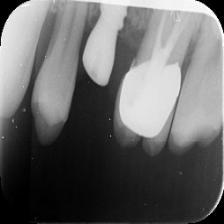
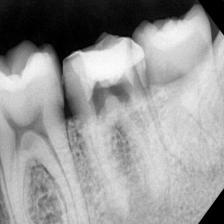
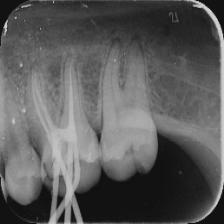
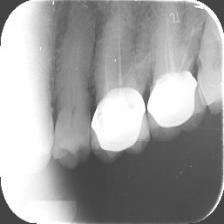
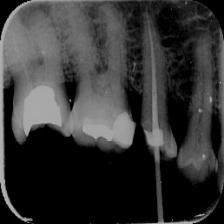
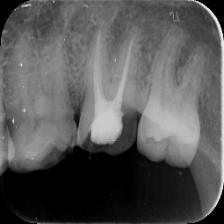
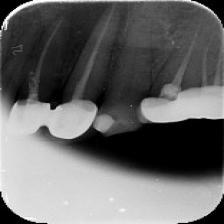
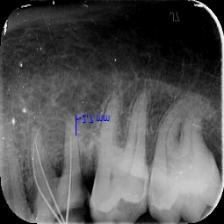
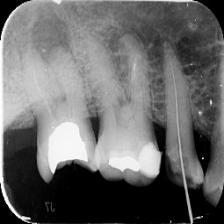
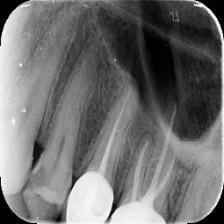
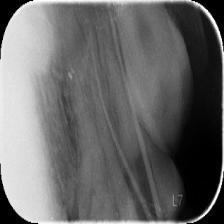
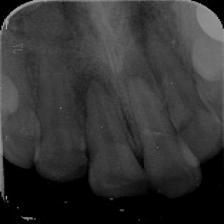
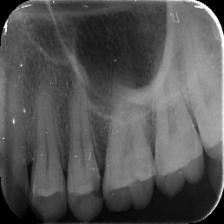
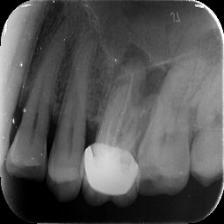
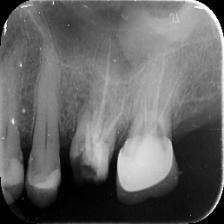
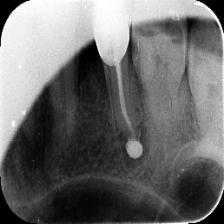
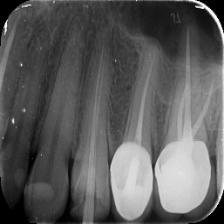
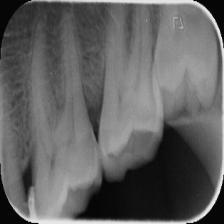
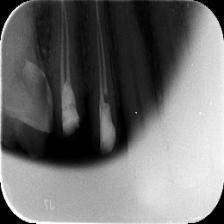
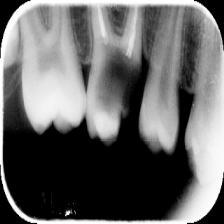
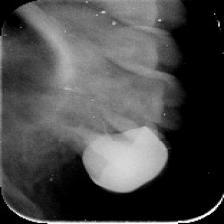
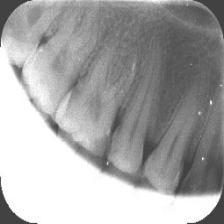
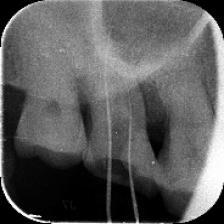
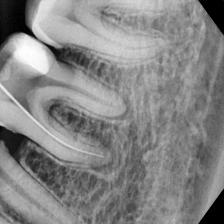
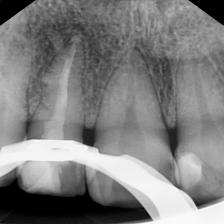
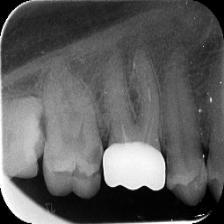
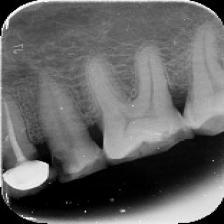
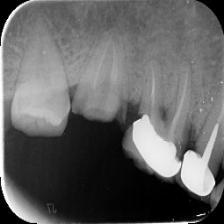
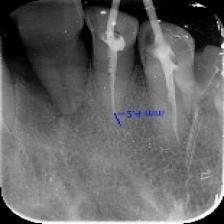
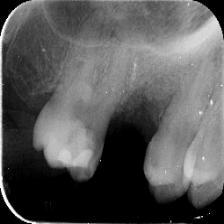
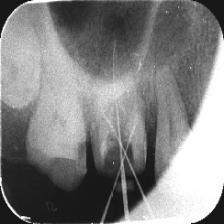
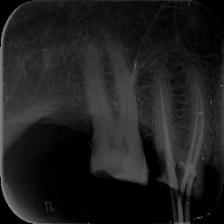
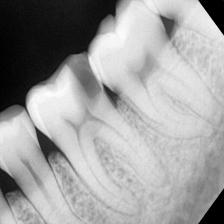
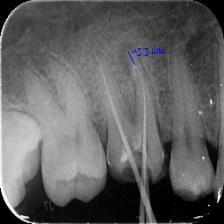
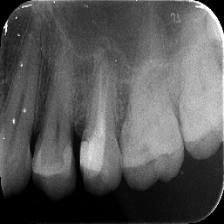
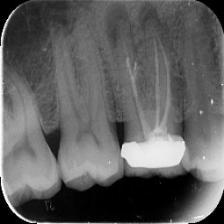
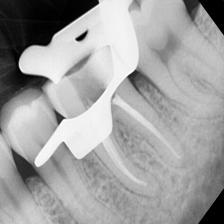
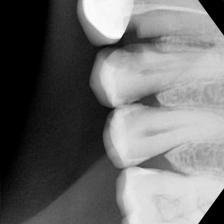
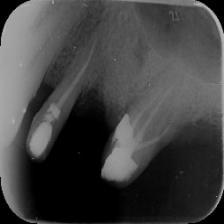
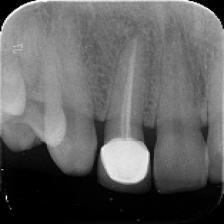
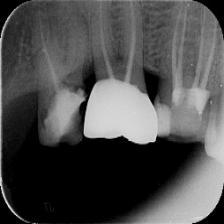
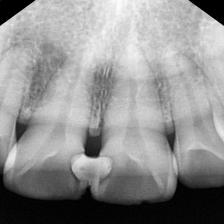
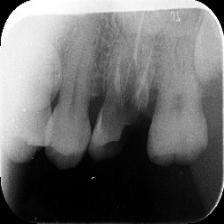
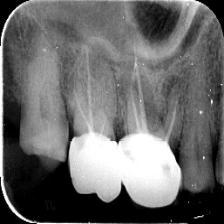
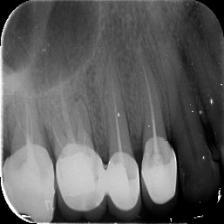
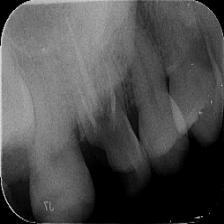
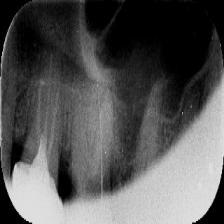
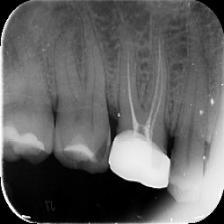
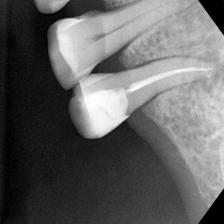
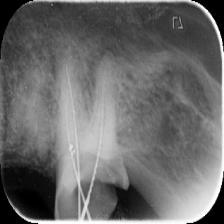
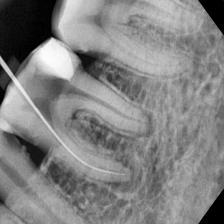
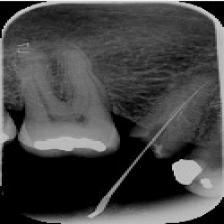
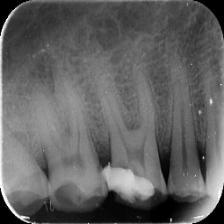
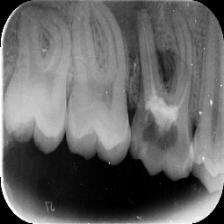
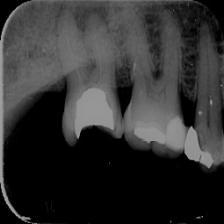
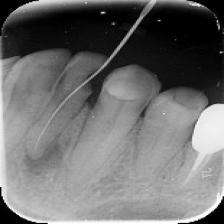
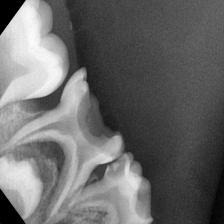
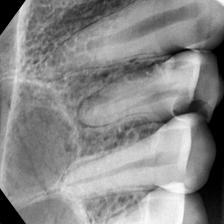
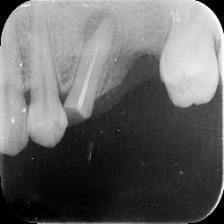
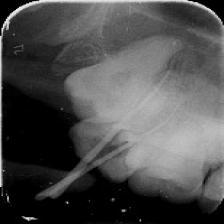
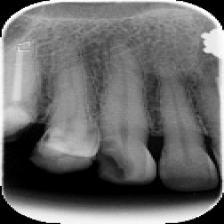
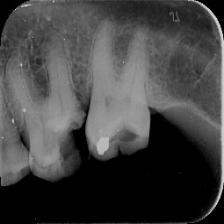
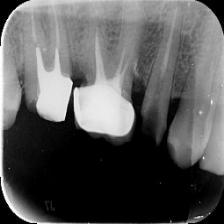
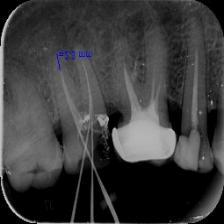
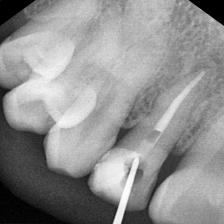
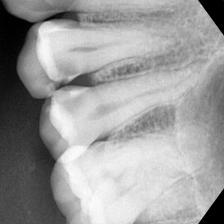
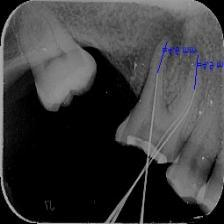
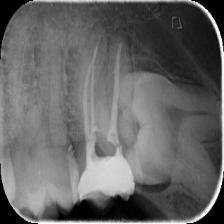
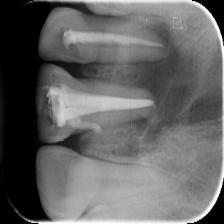
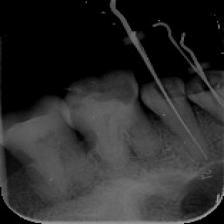
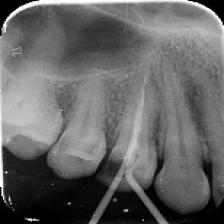
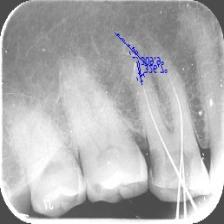
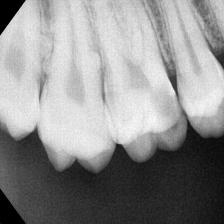
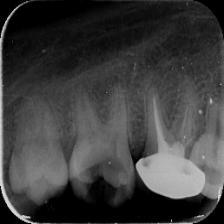
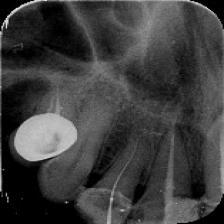
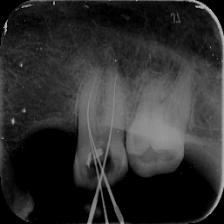
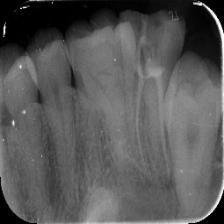
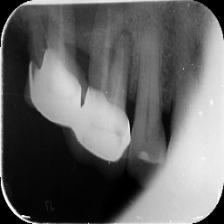

In [15]:
# @title Evaluate the model on all examples.
#
# The validation data consists of 10 images in a different domain than training
# data.
#%%time

print("Model predictions")
html_out = ""
for image, caption in make_predictions(validation_data_iterator(), batch_size=4):
  html_out += render_example(image, caption)
display(HTML(html_out))


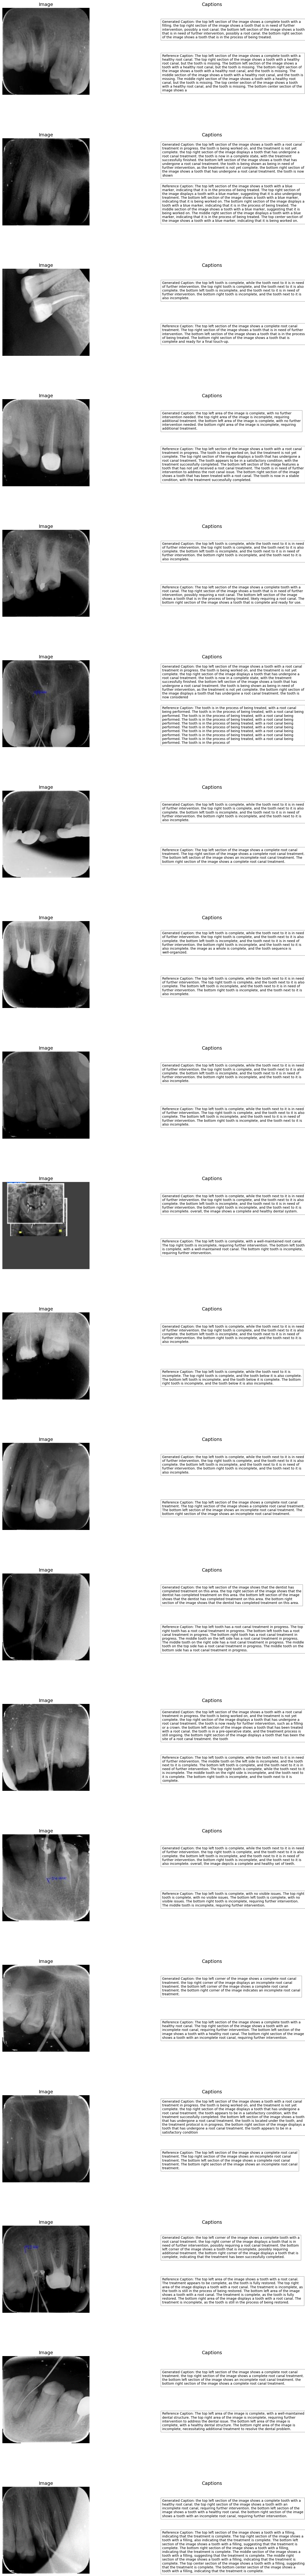

In [16]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
import json
import random

# Load ground truth captions from validation dataset
references = {}
with open("/kaggle/input/baselinedataset/root-canal-captioning_baseline/valid/preprocessed_valid.jsonl", "r") as f:
    for i, line in enumerate(f):
        example = json.loads(line)
        image_id = i  # Use a unique identifier
        caption = example.get("suffix", "No caption provided.")  # Default caption if key is missing
        references[image_id] = [caption]  # Store the reference caption as a list

# Generate model predictions (ensure `make_predictions` and `validation_data_iterator` are defined elsewhere)
hypotheses = {}
try:
    for i, (image, caption) in enumerate(make_predictions(validation_data_iterator(), batch_size=4)):
        hypotheses[i] = [caption]  # Store the generated caption as a list
except NameError:
    print("Ensure `make_predictions` and `validation_data_iterator` are properly defined.")

# Load images from a directory
def load_images_from_directory(directory_path):
    images = []
    image_filenames = sorted(os.listdir(directory_path))  # Get sorted image files in the directory
    for filename in image_filenames:
        if filename.lower().endswith((".jpg", ".png", ".jpeg")):  # Check for valid image file extensions
            img_path = os.path.join(directory_path, filename)
            try:
                img = Image.open(img_path).convert("RGB")  # Open the image and ensure it's in RGB format
                images.append(img)
            except Exception as e:
                print(f"Error loading image {filename}: {e}")
    return images

# Call the function to load images
image_directory = "/kaggle/input/baselinedataset/root-canal-captioning_baseline/valid"  # Replace with your image directory path
images = load_images_from_directory(image_directory)

def display_inference_results(images, references, predictions):
    num_samples = len(images)
    fig, axs = plt.subplots(num_samples, 2, figsize=(15, num_samples * 7))  # 2 columns: image and captions

    # Ensure axs is treated as a 2D array for consistent indexing
    if num_samples == 1:
        axs = np.expand_dims(axs, axis=0)

    for idx, (image, ref_caption, pred_caption) in enumerate(zip(images, references.values(), predictions.values())):
        # Ensure image is in the correct format (H, W, C)
        if isinstance(image, torch.Tensor):
            image = image.cpu().numpy()  # Convert tensor to numpy
            if image.ndim == 3:  # If it's a (C, H, W) tensor, convert to (H, W, C)
                image = np.transpose(image, (1, 2, 0))
        elif isinstance(image, Image.Image):
            image = np.array(image)  # Convert PIL image to numpy array

        # Display the image on the left
        axs[idx, 0].imshow(image)
        axs[idx, 0].axis('off')
        axs[idx, 0].set_title("Image", fontsize=14)

        # Display captions on the right: generated on top, reference below
        axs[idx, 1].text(0.05, 0.75, f"Generated Caption: {pred_caption[0]}", ha='left', va='center', wrap=True, 
                         fontsize=10, transform=axs[idx, 1].transAxes, 
                         bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray'))
        axs[idx, 1].text(0.05, 0.25, f"Reference Caption: {ref_caption[0]}", ha='left', va='center', wrap=True, 
                         fontsize=10, transform=axs[idx, 1].transAxes, 
                         bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray'))
        axs[idx, 1].axis('off')
        axs[idx, 1].set_title("Captions", fontsize=14)

    # Adjust subplot layout spacing
    plt.subplots_adjust(hspace=0.5, wspace=0.5)  # Increased spacing between rows and columns
    plt.show()

# Function to sample data
def sample_data(images, references, predictions, num_samples=10):
    # Ensure the number of samples does not exceed available data
    num_samples = min(num_samples, len(images), len(references), len(predictions))
    
    # Get random indices for sampling
    indices = random.sample(range(len(images)), num_samples)
    
    # Select the corresponding sampled images, references, and predictions
    sampled_images = [images[i] for i in indices]
    sampled_references = {i: references[i] for i in indices}
    sampled_predictions = {i: predictions[i] for i in indices}
    
    return sampled_images, sampled_references, sampled_predictions

# Sample random samples for visualization (e.g., 10)
sampled_images, sampled_references, sampled_predictions = sample_data(images, references, hypotheses, num_samples=20)

# Display results with the adjusted function
display_inference_results(sampled_images, sampled_references, sampled_predictions)


In [17]:
# Install required packages
!pip install scikit-learn nltk rouge-score autocorrect gensim
!pip install git+https://github.com/salaniz/pycocoevalcap.git
!pip install --upgrade nltk

import nltk
# Import necessary libraries
import json
from pycocoevalcap.bleu.bleu import Bleu  # BLEU scorer
from pycocoevalcap.cider.cider import Cider  # CIDEr scorer
from rouge_score import rouge_scorer  # ROUGE scorer
import nltk
from nltk.translate.meteor_score import meteor_score  # nltk METEOR scorer

# Load ground truth captions from validation dataset
references = {}
with open("/kaggle/input/baselinedataset/root-canal-captioning_baseline/valid/preprocessed_valid.jsonl", "r") as f:
    for i, line in enumerate(f):
        example = json.loads(line)
        image_id = i  # or use a unique identifier if available
        caption = example["suffix"]
        references[image_id] = [caption]  # Store the reference caption

# Generate model predictions (assuming make_predictions is defined in your code)
hypotheses = {}
for i, (image, caption) in enumerate(make_predictions(validation_data_iterator(), batch_size=4)):
    hypotheses[i] = [caption]  # Store the generated caption

# Evaluate using BLEU Score
bleu_scorer = Bleu()
bleu_score, _ = bleu_scorer.compute_score(references, hypotheses)
print(f"BLEU Score : {bleu_score}")

"""# Evaluate using METEOR Score (Switching to nltk implementation)
meteor_scores = []
for key in references:
    ref = references[key][0].lower().strip()  # Lowercase for consistency
    hyp = hypotheses[key][0].lower().strip()  # Lowercase for consistency
    score = meteor_score([ref], [hyp])
    meteor_scores.append(score)

# Compute average METEOR score
average_meteor_score = sum(meteor_scores) / len(meteor_scores)
print(f" METEOR Score (nltk) : {average_meteor_score}")"""

# Evaluate using ROUGE Score
rouge = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
rouge_scores = {'rouge1': 0, 'rouge2': 0, 'rougeL': 0}
num_samples = len(references)
for key in references:
    scores = rouge.score(references[key][0].lower(), hypotheses[key][0].lower())  # Lowercase for consistency
    for rouge_key in rouge_scores:
        rouge_scores[rouge_key] += scores[rouge_key].fmeasure

# Average ROUGE Scores
for key in rouge_scores:
    rouge_scores[key] /= num_samples
print(f"ROUGE Scores : {rouge_scores}")

# Evaluate using CIDEr Score
cider_scorer = Cider()
cider_score, _ = cider_scorer.compute_score(references, hypotheses)
print(f"CIDEr Score : {cider_score}")

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 622.8/622.8 kB 13.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 44.1 MB/s eta 0:00:00
  Created wheel for autocorrect: filename=autocorrect-2.6.1-py3-none-any.whl size=622363 sha256=5f3ed1d0344650dc16ac340a95daa8f329adf2b398340a9a1fce30547cae8887
  Stored in directory: /root/.cache/pip/wheels/b5/7b/6d/b76b29ce11ff8e2521c8c7dd0e5bfee4fb1789d76193124343
Successfully built autocorrect
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cuml 24.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cesium 0.12.3 requires 

In [18]:
!pip install sacrebleu
import sacrebleu

# Calculate a METEOR-like score using precision, recall, and F1-score approach
def custom_meteor_like_score(reference, hypothesis):
    # Sacrebleu supports corpus-level BLEU score, but we can leverage it for tokenized precision/recall
    tokenized_reference = [reference.split()]  # Tokenized reference (list of tokens)
    tokenized_hypothesis = hypothesis.split()  # Tokenized hypothesis (list of tokens)

    # Calculate precision and recall
    overlap = len(set(tokenized_reference[0]) & set(tokenized_hypothesis))
    precision = overlap / len(tokenized_hypothesis) if len(tokenized_hypothesis) > 0 else 0
    recall = overlap / len(tokenized_reference[0]) if len(tokenized_reference[0]) > 0 else 0

    # Compute F1-like score (Harmonic Mean)
    if precision + recall > 0:
        score = (2 * precision * recall) / (precision + recall)
    else:
        score = 0

    # Optionally apply a penalty for longer sequences if desired (e.g., length normalization)
    # Here we keep it simple without a penalty term
    return score

# Iterate over references and hypotheses to calculate scores
meteor_like_scores = []
for key in references:
    ref = references[key][0].lower().strip()  # Lowercase for consistency
    hyp = hypotheses[key][0].lower().strip()  # Lowercase for consistency
    score = custom_meteor_like_score(ref, hyp)
    meteor_like_scores.append(score)

# Compute average METEOR-like score
average_meteor_like_score = sum(meteor_like_scores) / len(meteor_like_scores)
print(f"Custom METEOR-Like Score (using sacrebleu approach): {average_meteor_like_score}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.0/104.0 kB 5.2 MB/s eta 0:00:00
Custom METEOR-Like Score (using sacrebleu approach): 0.17729891388250224


In [19]:
# Install required packages
!pip install scikit-learn nltk rouge-score autocorrect gensim
!pip install git+https://github.com/salaniz/pycocoevalcap.git

# Download necessary NLTK data packages (except wordnet)
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

# Import necessary libraries
from autocorrect import Speller
from gensim.models import KeyedVectors
import json
import string
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk import pos_tag
from collections import Counter
from rouge_score import rouge_scorer  # Correct import for ROUGE scorer
from pycocoevalcap.bleu.bleu import Bleu  # BLEU scorer
from pycocoevalcap.meteor.meteor import Meteor  # METEOR scorer
from pycocoevalcap.cider.cider import Cider  # CIDEr scorer

# Initialize spell checker, stemmer, and stop words
spell = Speller()
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

# Function to perform spell correction
def correct_spelling(text):
    return spell(text)

# Function to expand common contractions
contractions = {
    "can't": "cannot", "won't": "will not", "n't": " not", "'re": " are", "'s": " is", "'d": " would", "'ll": " will", "'ve": " have", "'m": " am"
}

def expand_contractions(text):
    for contraction, full_form in contractions.items():
        text = re.sub(contraction, full_form, text)
    return text

# Function for POS filtering to retain meaningful words
def filter_pos(tokens):
    # Only retain nouns, verbs, and adjectives
    allowed_tags = {'NN', 'VB', 'JJ'}
    return [word for word, tag in pos_tag(tokens) if tag[:2] in allowed_tags]

# Function to remove low-frequency words based on a dataset-wide frequency count
def remove_low_frequency_words(tokens, frequency_dict, threshold=2):
    return [word for word in tokens if frequency_dict[word] > threshold]

# Preprocessing function with advanced techniques
def preprocess_text(text, frequency_dict):
    # Correct spelling errors
    text = correct_spelling(text)
    
    # Lowercase the text
    text = text.lower()

    # Expand contractions
    text = expand_contractions(text)
    
    # Remove digits and special characters
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stop words and apply POS filtering
    tokens = [word for word in tokens if word not in stop_words and word.isalpha()]
    tokens = filter_pos(tokens)

    # Apply stemming
    tokens = [stemmer.stem(word) for word in tokens]

    # Remove low-frequency words
    tokens = remove_low_frequency_words(tokens, frequency_dict)

    return ' '.join(tokens).strip()

# Build a frequency dictionary from your dataset
def build_frequency_dict(texts):
    all_words = []
    for text in texts:
        tokens = word_tokenize(text.lower())
        all_words.extend([word for word in tokens if word.isalpha()])
    return Counter(all_words)

# Load ground truth captions from validation dataset
references = {}
with open("/kaggle/input/baselinedataset/root-canal-captioning_baseline/valid/preprocessed_valid.jsonl", "r") as f:
    for i, line in enumerate(f):
        example = json.loads(line)
        image_id = i  # or use a unique identifier if available
        caption = example["suffix"]
        references[image_id] = [caption]  # Store the reference caption

# Generate model predictions (assuming make_predictions is defined in your code)
hypotheses = {}
for i, (image, caption) in enumerate(make_predictions(validation_data_iterator(), batch_size=4)):
    hypotheses[i] = [caption]  # Store the generated caption

# Build frequency dictionary for low-frequency word removal
all_captions = [caption[0] for caption in references.values()] + [caption[0] for caption in hypotheses.values()]
frequency_dict = build_frequency_dict(all_captions)

# Preprocess the reference and hypothesis captions
preprocessed_references = {}
for image_id, captions in references.items():
    preprocessed_references[image_id] = [preprocess_text(caption, frequency_dict) for caption in captions]

preprocessed_hypotheses = {}
for image_id, captions in hypotheses.items():
    preprocessed_hypotheses[image_id] = [preprocess_text(caption, frequency_dict) for caption in captions]

# Evaluate using BLEU Score
bleu_scorer = Bleu()
bleu_score, _ = bleu_scorer.compute_score(preprocessed_references, preprocessed_hypotheses)
print(f"BLEU Score : {bleu_score}")

# Evaluate using METEOR Score
meteor_scorer = Meteor()
meteor_score, _ = meteor_scorer.compute_score(preprocessed_references, preprocessed_hypotheses)
print(f"METEOR Score : {meteor_score}")

# Evaluate using ROUGE Score
rouge = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
rouge_scores = {'rouge1': 0, 'rouge2': 0, 'rougeL': 0}
num_samples = len(preprocessed_references)
for key in preprocessed_references:
    scores = rouge.score(' '.join(preprocessed_references[key]), preprocessed_hypotheses[key][0])
    for rouge_key in rouge_scores:
        rouge_scores[rouge_key] += scores[rouge_key].fmeasure

# Average ROUGE Scores
for key in rouge_scores:
    rouge_scores[key] /= num_samples

print(f"ROUGE Scores : {rouge_scores}")

# Evaluate using CIDEr Score
cider_scorer = Cider()
cider_score, _ = cider_scorer.compute_score(preprocessed_references, preprocessed_hypotheses)
print(f"CIDEr Score : {cider_score}")


  Cloning https://github.com/salaniz/pycocoevalcap.git to /tmp/pip-req-build-2w6n7wlq
  Running command git clone --filter=blob:none --quiet https://github.com/salaniz/pycocoevalcap.git /tmp/pip-req-build-2w6n7wlq
  Resolved https://github.com/salaniz/pycocoevalcap.git to commit a24f74c408c918f1f4ec34e9514bc8a76ce41ffd
  Preparing metadata (setup.py) ... done
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
{'testlen': 3429, 'reflen': 3266, 'guess': [3429, 3290, 3151, 3012], 'correct': [1996, 1320, 816, 578]}
ratio: 1.0499081445189682
BLEU Score : [0.5820939049283809, 0.4832652221354249, 0.3925282760269365, 0